In [1]:
#import necessary packages 
import xarray as xr
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import math
import cdsapi
import netCDF4
import earthaccess
import os
import tempfile
import sys
import json
import urllib3
import certifi
import requests
from time import sleep
from http.cookiejar import CookieJar
import urllib.request
from urllib.parse import urlencode
import getpass
from datetime import datetime
import h5py
from tqdm.auto import tqdm
import concurrent.futures
import warnings
from typing import Tuple, Optional,List, Dict
from pathlib import Path
import ftplib
import ssl
import json
import sys
import time
import uuid
from tqdm import tqdm



/opt/anaconda3/envs/climate_env/lib/python3.10/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
merra2_data=xr.open_dataset("merra2_data/merra2_monthly_soil_moisture_2013-01_2023-12.nc", engine="netcdf4")
nldas_data= xr.open_dataset("nldas_data_2013-01-01_2023-12-31.nc", engine="netcdf4")
fldas_data= xr.open_dataset("fldas_data_2013-01-01_2023-12-31.nc", engine="netcdf4")
gldas_data= xr.open_dataset("gldas_data_2013-01-01_2023-12-31.nc", engine="netcdf4")
era5_data=xr.open_dataset('/Users/alicemonroe/Downloads/48d4a4137072514563387dd5691e5614.grib',engine='cfgrib')


In [3]:
import xarray as xr
import numpy as np
import logging
from pathlib import Path

# Set up logging
logging.basicConfig(level=logging.INFO)
logger = logging.getLogger(__name__)

# Dictionary mapping model names to their variable names
VARIABLE_NAMES = {
    'merra2': 'SFMC',
    'nldas': 'SoilM_0_10cm',
    'fldas': 'SoilMoi00_10cm_tavg',
    'gldas': 'SoilMoi0_10cm_inst',
    'era5': 'swvl1'
}

def load_dataset(file_path, model_name):
    """
    Load a dataset with appropriate engine selection.
    
    Parameters:
    -----------
    file_path : str
        Path to the dataset file
    model_name : str
        Name of the model for variable selection
        
    Returns:
    --------
    xarray.Dataset
        Loaded dataset
    """
    try:
        # Select appropriate engine based on file extension
        engine = 'cfgrib' if Path(file_path).suffix == '.grib' else 'netcdf4'
        dataset = xr.open_dataset(file_path, engine=engine)
        
        # Verify the expected variable exists
        var_name = VARIABLE_NAMES.get(model_name)
        if var_name not in dataset:
            raise KeyError(f"Expected variable {var_name} not found in {model_name} dataset")
            
        logger.info(f"Successfully loaded {model_name} dataset")
        return dataset
        
    except Exception as e:
        logger.error(f"Error loading {model_name} dataset: {str(e)}")
        raise

def normalize_data(data):
    """
    Normalize data using z-score normalization.
    
    Parameters:
    -----------
    data : xarray.DataArray
        Data to normalize
        
    Returns:
    --------
    xarray.DataArray
        Normalized data
    """
    mean = data.mean()
    std = data.std()
    
    # Check for zero standard deviation
    if std == 0:
        raise ValueError("Standard deviation is zero")
        
    return (data - mean) / std

def get_dataset_stats(dataset, var_name):
    """
    Get basic statistics for a dataset.
    
    Parameters:
    -----------
    dataset : xarray.Dataset
        Dataset to analyze
    var_name : str
        Variable name to analyze
        
    Returns:
    --------
    dict
        Dictionary containing basic statistics
    """
    data = dataset[var_name]
    
    return {
        'mean': float(data.mean()),
        'std': float(data.std()),
        'min': float(data.min()),
        'max': float(data.max()),
        'missing_values': int(data.isnull().sum())
    }

# Load all datasets
try:
    # Load datasets
    merra2_data = load_dataset("merra2_data/merra2_monthly_soil_moisture_2013-01_2023-12.nc", 'merra2')
    nldas_data = load_dataset("nldas_data_2013-01-01_2023-12-31.nc", 'nldas')
    fldas_data = load_dataset("fldas_data_2013-01-01_2023-12-31.nc", 'fldas')
    gldas_data = load_dataset("gldas_data_2013-01-01_2023-12-31.nc", 'gldas')
    era5_data = load_dataset('/Users/alicemonroe/Downloads/48d4a4137072514563387dd5691e5614.grib', 'era5')

    # Normalize datasets
    merra2_norm = normalize_data(merra2_data[VARIABLE_NAMES['merra2']])
    nldas_norm = normalize_data(nldas_data[VARIABLE_NAMES['nldas']])
    fldas_norm = normalize_data(fldas_data[VARIABLE_NAMES['fldas']])
    gldas_norm = normalize_data(gldas_data[VARIABLE_NAMES['gldas']])
    era5_norm = normalize_data(era5_data[VARIABLE_NAMES['era5']])

    # Print statistics for each dataset
    for model, var_name in VARIABLE_NAMES.items():
        dataset = locals()[f"{model}_data"]
        print(f"\nStats for {model}:")
        print(get_dataset_stats(dataset, var_name))

except Exception as e:
    logger.error(f"Error in processing: {str(e)}")

# Example of accessing normalized data:
print("\nFirst few values of normalized MERRA2 data:")
print(merra2_norm.values.flatten()[:5])

INFO:__main__:Successfully loaded merra2 dataset
INFO:__main__:Successfully loaded nldas dataset
INFO:__main__:Successfully loaded fldas dataset
INFO:__main__:Successfully loaded gldas dataset
INFO:__main__:Successfully loaded era5 dataset



Stats for merra2:
{'mean': 0.26243728399276733, 'std': 0.05849142372608185, 'min': 0.08408477902412415, 'max': 0.40693116188049316, 'missing_values': 0}

Stats for nldas:
{'mean': 29.37762451171875, 'std': 7.005784034729004, 'min': 2.967447280883789, 'max': 47.59986114501953, 'missing_values': 31416}

Stats for fldas:
{'mean': 0.3621697723865509, 'std': 0.049683213233947754, 'min': 0.1411125510931015, 'max': 0.4678364396095276, 'missing_values': 49104}

Stats for gldas:
{'mean': 31.479463577270508, 'std': 6.497677326202393, 'min': 8.321121215820312, 'max': 47.58256912231445, 'missing_values': 7788}

Stats for era5:
{'mean': 0.30423209071159363, 'std': 0.09435505419969559, 'min': 0.009994503110647202, 'max': 0.49442291259765625, 'missing_values': 16104}

First few values of normalized MERRA2 data:
[1.77362149 1.10586802 0.93846447 0.99956309 1.06703729]



=== Data Diagnostics Report ===

--------------------
MERRA2
--------------------
Shape: 132 × 10 × 13
Memory Usage: 0.07 MB
Value Range: 0.0841 to 0.4069
Mean ± Std: 0.2624 ± 0.0585
Median (IQR): 0.2646 (0.0812)
Missing Data: 0.00%
Outliers: 0.17%

--------------------
NLDAS
--------------------
Shape: 132 × 36 × 63
Memory Usage: 1.14 MB
Value Range: 2.9674 to 47.5999
Mean ± Std: 29.3776 ± 7.0062
Median (IQR): 28.3492 (8.2085)
Missing Data: 10.49%
Outliers: 2.84%

--------------------
FLDAS
--------------------
Shape: 132 × 45 × 79
Memory Usage: 1.79 MB
Value Range: 0.1411 to 0.4678
Mean ± Std: 0.3622 ± 0.0497
Median (IQR): 0.3690 (0.0598)
Missing Data: 10.46%
Outliers: 3.14%

--------------------
GLDAS
--------------------
Shape: 132 × 18 × 32
Memory Usage: 0.29 MB
Value Range: 8.3211 to 47.5826
Mean ± Std: 31.4795 ± 6.4977
Median (IQR): 30.1789 (7.9894)
Missing Data: 10.24%
Outliers: 2.12%

--------------------
ERA5
--------------------
Shape: 132 × 46 × 80
Memory Usage: 1.85 MB
Va

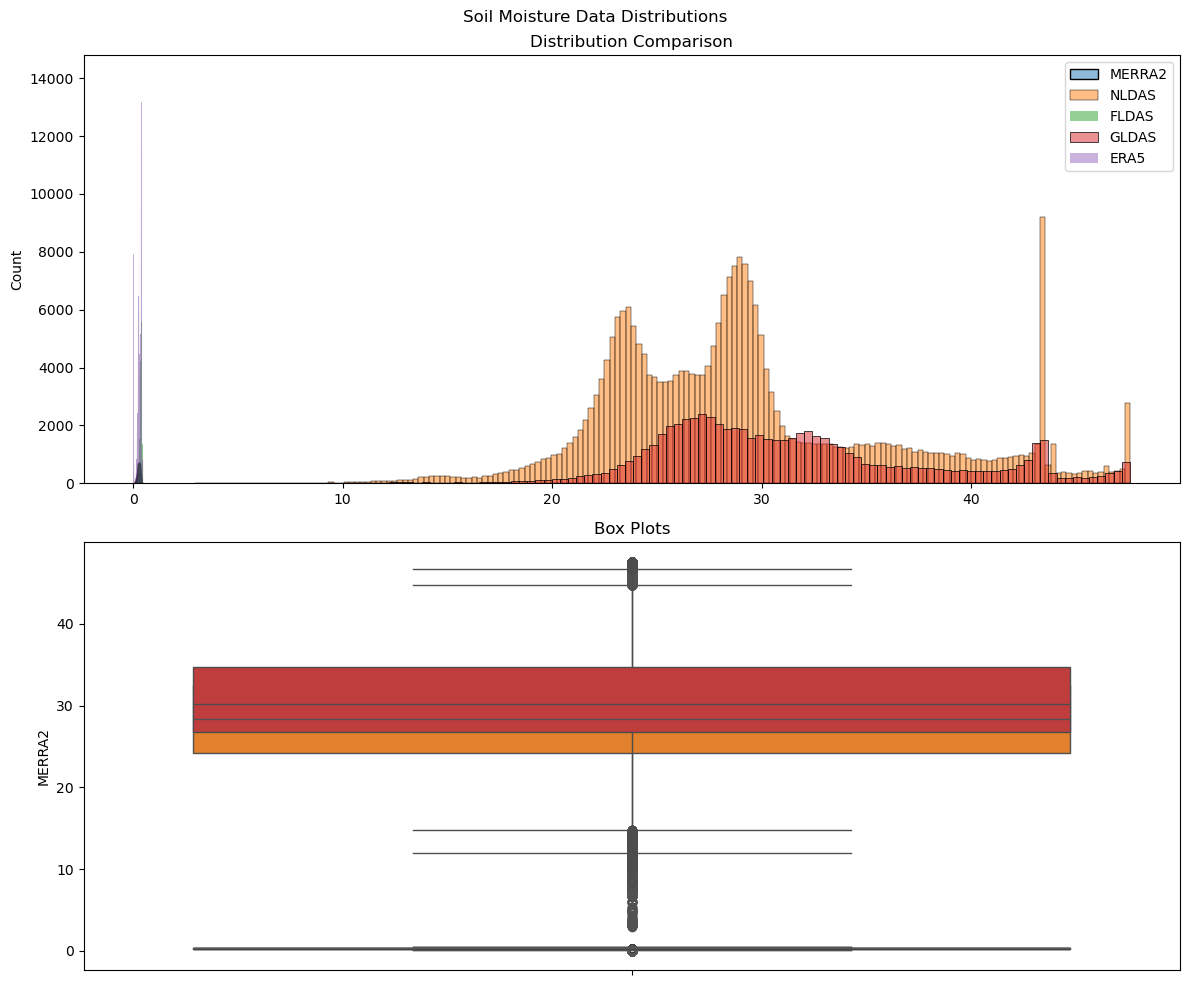


=== Cross-Dataset Comparison ===
            Mean     Std  Missing_Percentage  Outlier_Percentage
Dataset                                                         
MERRA2    0.2624  0.0585              0.0000              0.1690
NLDAS    29.3776  7.0062             10.4938              2.8422
FLDAS     0.3622  0.0497             10.4641              3.1350
GLDAS    31.4795  6.4977             10.2431              2.1159
ERA5      0.3042  0.0944              3.3152              4.0174
Dataset
MERRA2     0.262437
NLDAS     29.377626
FLDAS      0.362170
GLDAS     31.479464
ERA5       0.304232
Name: Mean, dtype: float32
Mean                       0.262437
Std                        0.058491
Min                        0.084085
Max                        0.406931
NaN_Count                         0
Total_Values                  17160
Valid_Values                  17160
Missing_Percentage              0.0
Dimensions            132 × 10 × 13
Memory_MB                   0.06546
Q1              

In [4]:
import xarray as xr
import numpy as np
import pandas as pd
from typing import Dict, Union
import seaborn as sns
import matplotlib.pyplot as plt

# Define variable names mapping
VARIABLE_MAPPING = {
    'MERRA2': 'SFMC',
    'NLDAS': 'SoilM_0_10cm',
    'FLDAS': 'SoilMoi00_10cm_tavg',
    'GLDAS': 'SoilMoi0_10cm_inst',
    'ERA5': 'swvl1'
}

def check_data_properties(datasets_dict: Dict[str, Union[xr.Dataset, xr.DataArray]], 
                         plot_distributions: bool = True) -> pd.DataFrame:
    """
    Comprehensive diagnostic check of soil moisture datasets.
    
    Parameters:
    -----------
    datasets_dict : Dict
        Dictionary of datasets with model names as keys
    plot_distributions : bool
        Whether to plot distribution visualizations
        
    Returns:
    --------
    pd.DataFrame
        Summary statistics for all datasets
    """
    # Initialize storage for statistics
    stats_list = []
    
    # Create figure for distributions if needed
    if plot_distributions:
        fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(12, 10))
        fig.suptitle('Soil Moisture Data Distributions')
    
    print("\n=== Data Diagnostics Report ===")
    
    for name, data in datasets_dict.items():
        print(f"\n{'-'*20}\n{name}\n{'-'*20}")
        
        try:
            # Extract the correct data array using mapping
            var_name = VARIABLE_MAPPING.get(name)
            if var_name is None:
                raise KeyError(f"No variable mapping found for {name}")
                
            data_array = data[var_name] if isinstance(data, xr.Dataset) else data
            
            # Basic validation
            if not isinstance(data_array, xr.DataArray):
                raise TypeError(f"Expected xarray.DataArray, got {type(data_array)}")
            
            # Get the actual values and compute statistics
            values = data_array.values
            flattened = values.flatten()
            valid_values = flattened[~np.isnan(flattened)]
            
            # Compute basic statistics
            stats = {
                'Dataset': name,
                'Mean': np.mean(valid_values),
                'Std': np.std(valid_values),
                'Min': np.min(valid_values),
                'Max': np.max(valid_values),
                'NaN_Count': np.sum(np.isnan(flattened)),
                'Total_Values': len(flattened),
                'Valid_Values': len(valid_values),
                'Missing_Percentage': (np.sum(np.isnan(flattened)) / len(flattened)) * 100,
                'Dimensions': ' × '.join(map(str, values.shape)),
                'Memory_MB': values.nbytes / (1024 * 1024)
            }
            
            # Add quartile statistics
            quartiles = np.percentile(valid_values, [25, 50, 75])
            stats.update({
                'Q1': quartiles[0],
                'Median': quartiles[1],
                'Q3': quartiles[2],
                'IQR': quartiles[2] - quartiles[0]
            })
            
            # Check for potential outliers
            iqr = stats['IQR']
            lower_bound = stats['Q1'] - (1.5 * iqr)
            upper_bound = stats['Q3'] + (1.5 * iqr)
            outliers = np.sum((valid_values < lower_bound) | (valid_values > upper_bound))
            stats['Outlier_Count'] = outliers
            stats['Outlier_Percentage'] = (outliers / len(valid_values)) * 100
            
            stats_list.append(stats)
            
            # Print detailed report
            print(f"Shape: {stats['Dimensions']}")
            print(f"Memory Usage: {stats['Memory_MB']:.2f} MB")
            print(f"Value Range: {stats['Min']:.4f} to {stats['Max']:.4f}")
            print(f"Mean ± Std: {stats['Mean']:.4f} ± {stats['Std']:.4f}")
            print(f"Median (IQR): {stats['Median']:.4f} ({stats['IQR']:.4f})")
            print(f"Missing Data: {stats['Missing_Percentage']:.2f}%")
            print(f"Outliers: {stats['Outlier_Percentage']:.2f}%")
            
            # Create visualizations if requested
            if plot_distributions:
                # Histogram
                sns.histplot(valid_values, label=name, alpha=0.5, ax=ax1)
                
                # Box plot data
                sns.boxplot(data=pd.Series(valid_values, name=name), ax=ax2)
                
        except Exception as e:
            print(f"Error processing {name}: {str(e)}")
            continue
    
    if plot_distributions:
        ax1.set_title('Distribution Comparison')
        ax1.legend()
        ax2.set_title('Box Plots')
        plt.tight_layout()
        plt.show()
    
    # Create summary DataFrame
    summary_df = pd.DataFrame(stats_list)
    summary_df = summary_df.set_index('Dataset')
    
    print("\n=== Cross-Dataset Comparison ===")
    print(summary_df[['Mean', 'Std', 'Missing_Percentage', 'Outlier_Percentage']].round(4))
    
    return summary_df

# Example usage:
datasets = {
    'MERRA2': merra2_data['SFMC'],  # Assuming this is already a DataArray
    'NLDAS': nldas_data,
    'FLDAS': fldas_data,
    'GLDAS': gldas_data,
    'ERA5': era5_data
}

# Run with visualizations
summary_stats = check_data_properties(datasets, plot_distributions=True)

# Access specific statistics
print(summary_stats['Mean'])  # Get means for all datasets
print(summary_stats.loc['MERRA2'])  # Get all stats for MERRA2


Processing MERRA2...
Successfully processed MERRA2
Shape: (132, 46, 80)
Valid data points: 455400

Processing NLDAS...
Successfully processed NLDAS
Shape: (132, 46, 80)
Valid data points: 385836

Processing FLDAS...
Successfully processed FLDAS
Shape: (132, 46, 80)
Valid data points: 389400

Processing GLDAS...
Successfully processed GLDAS
Shape: (132, 46, 80)
Valid data points: 356532

Processing ERA5...
Successfully processed ERA5
Shape: (132, 46, 80)
Valid data points: 463980


/var/folders/w6/0tkgm2g11c9202ygt6n5r_qh0000gn/T/ipykernel_15744/3053427324.py:117: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  corr = stats.pearsonr(ts1_clean, ts2_clean)[0]


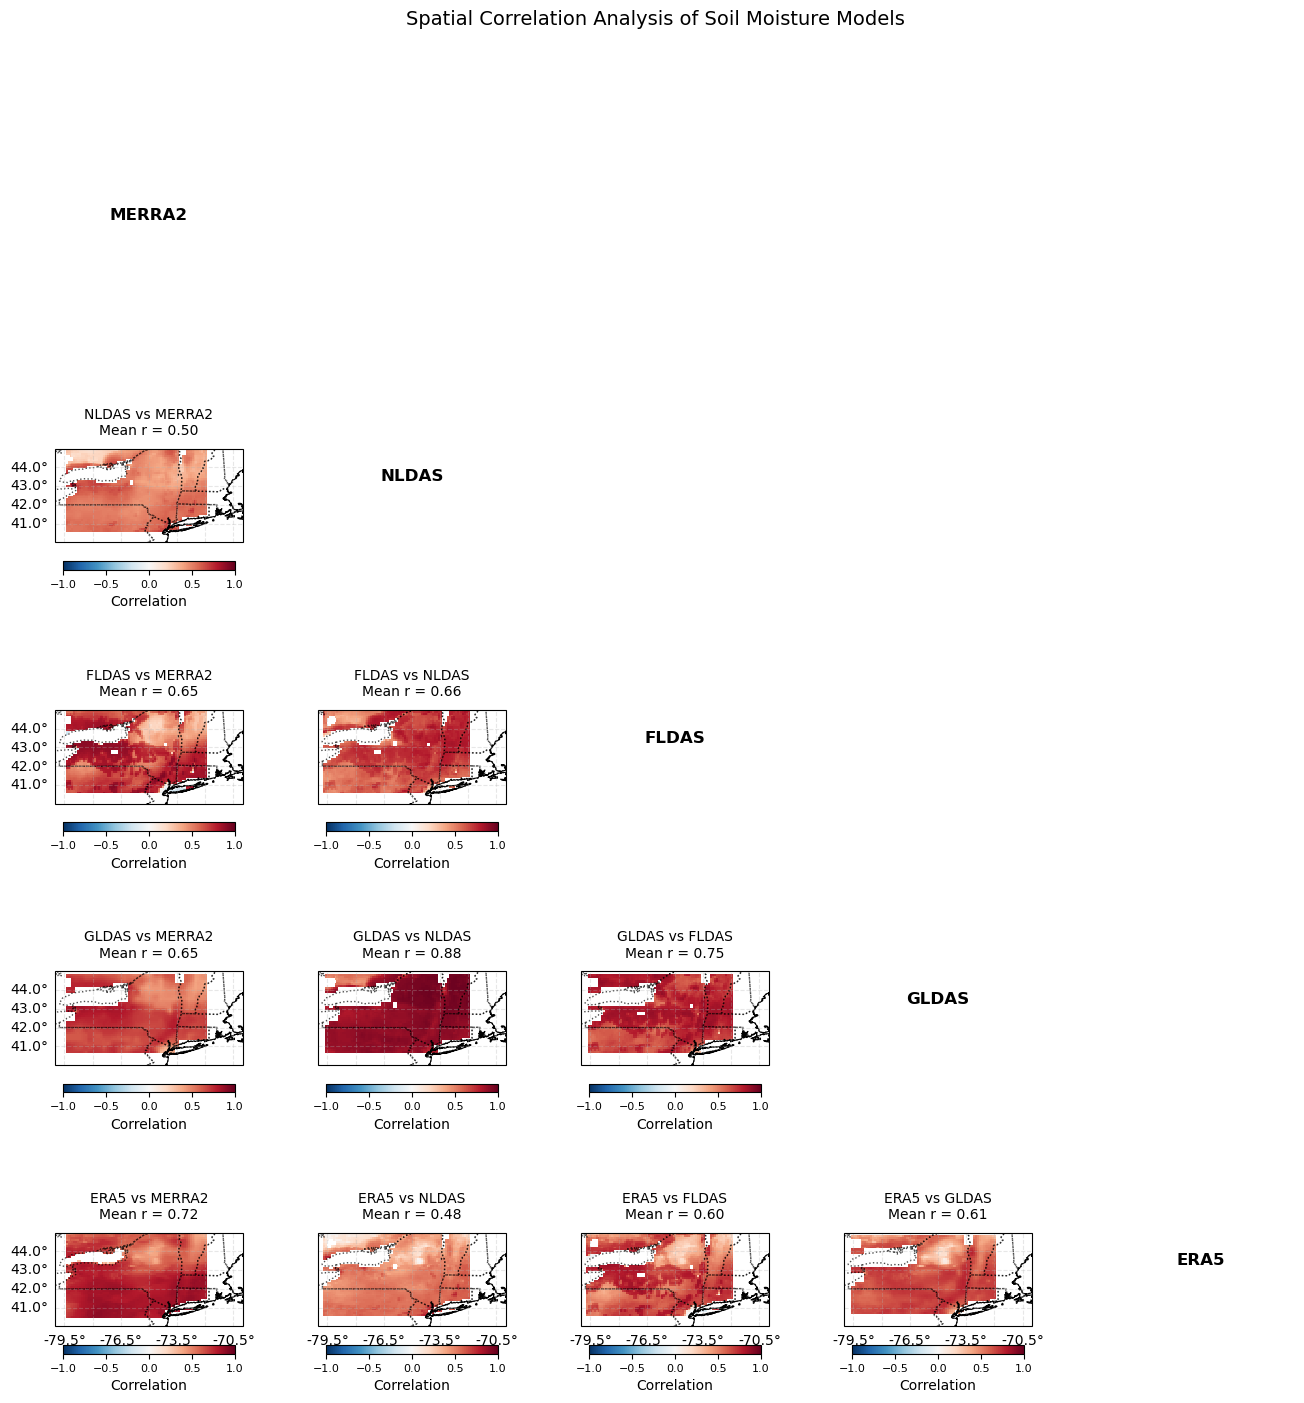

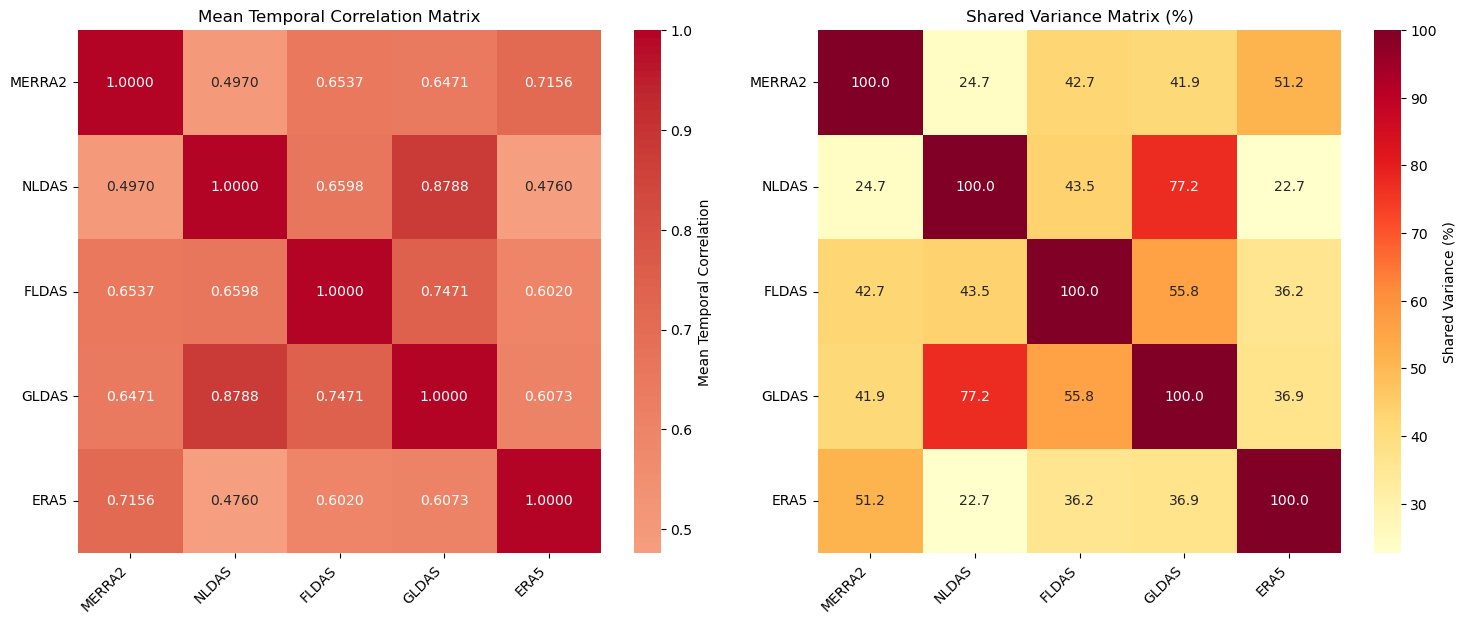

In [5]:
from typing import Dict, Tuple, Optional
import numpy as np
import xarray as xr
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from scipy import stats
import cartopy.crs as ccrs
import cartopy.feature as cfeature

# Define the model names
model_names = ['MERRA2', 'NLDAS', 'FLDAS', 'GLDAS', 'ERA5']

def regrid_and_analyze(datasets_dict: Dict[str, xr.DataArray], 
                      plot_spatial: bool = True) -> Tuple[pd.DataFrame, pd.DataFrame, Dict]:
    """
    Regrid all datasets to ERA5 grid and compute correlation statistics with enhanced
    spatial analysis and visualization capabilities.
    """
    names = list(datasets_dict.keys())
    n_datasets = len(names)
    
    # Get reference coordinates from ERA5
    era5_data = datasets_dict['ERA5']
    
    # Create target grid using ERA5 coordinates
    target_grid = xr.Dataset({
        'lat': (['lat'], era5_data.latitude.values),
        'lon': (['lon'], era5_data.longitude.values)
    })
    
    # Initialize matrices and spatial correlation storage
    covariance_matrix = np.zeros((n_datasets, n_datasets))
    shared_variance_matrix = np.zeros((n_datasets, n_datasets))
    spatial_correlations = {}
    
    # Configuration for different datasets
    regrid_configs = {
        'MERRA2': {'var': 'SFMC', 'lat': 'lat', 'lon': 'lon'},
        'NLDAS': {'var': 'SoilM_0_10cm', 'lat': 'lat', 'lon': 'lon'},
        'FLDAS': {'var': 'SoilMoi00_10cm_tavg', 'lat': 'Y', 'lon': 'X'},
        'GLDAS': {'var': 'SoilMoi0_10cm_inst', 'lat': 'lat', 'lon': 'lon'},
        'ERA5': {'var': 'swvl1', 'lat': 'latitude', 'lon': 'longitude'}
    }
    
    # Process and regrid datasets
    regridded_data = {}
    for name, config in regrid_configs.items():
        try:
            print(f"\nProcessing {name}...")
            data = datasets_dict[name]
            
            # Extract variable if dataset
            if isinstance(data, xr.Dataset):
                data = data[config['var']]
            
            # Rename coordinates if needed
            if config['lat'] != 'lat' or config['lon'] != 'lon':
                data = data.rename({
                    config['lat']: 'lat',
                    config['lon']: 'lon'
                })
            
            # Handle coordinate ordering
            if data.lat.values[0] > data.lat.values[-1]:
                data = data.reindex(lat=data.lat[::-1])
            
            # Regrid using bilinear interpolation
            regridded = data.interp(
                lat=target_grid.lat,
                lon=target_grid.lon,
                method='linear',
                kwargs={'fill_value': np.nan}
            )
            
            # Ensure consistent dimensions
            regridded = regridded.transpose('time', 'lat', 'lon')
            
            # Standardize the data
            regridded = (regridded - regridded.mean()) / regridded.std()
            
            regridded_data[name] = regridded
            
            print(f"Successfully processed {name}")
            print(f"Shape: {regridded.shape}")
            print(f"Valid data points: {np.sum(~np.isnan(regridded.values))}")
            
        except Exception as e:
            print(f"Error processing {name}: {str(e)}")
            continue
    
    # Calculate spatial correlations and statistics
    for i, name1 in enumerate(names):
        for j, name2 in enumerate(names):
            if name1 not in regridded_data or name2 not in regridded_data:
                continue
                
            data1 = regridded_data[name1].values
            data2 = regridded_data[name2].values
            
            # Initialize spatial correlation array
            spatial_corr = np.full((data1.shape[1], data1.shape[2]), np.nan)
            
            # Calculate point-by-point temporal correlations
            for lat_idx in range(data1.shape[1]):
                for lon_idx in range(data1.shape[2]):
                    ts1 = data1[:, lat_idx, lon_idx]
                    ts2 = data2[:, lat_idx, lon_idx]
                    
                    # Check for valid data
                    mask = ~(np.isnan(ts1) | np.isnan(ts2))
                    if np.sum(mask) > 10:  # Require at least 10 valid points
                        ts1_clean = ts1[mask]
                        ts2_clean = ts2[mask]
                        
                        # Calculate correlation
                        corr = stats.pearsonr(ts1_clean, ts2_clean)[0]
                        spatial_corr[lat_idx, lon_idx] = corr
            
            # Store spatial correlation map
            spatial_correlations[f"{name1}_vs_{name2}"] = {
                'correlation_map': spatial_corr,
                'lat': target_grid.lat.values,
                'lon': target_grid.lon.values
            }
            
            # Calculate matrix values
            valid_corrs = spatial_corr[~np.isnan(spatial_corr)]
            if len(valid_corrs) > 0:
                covariance_matrix[i,j] = np.mean(valid_corrs)
                shared_variance_matrix[i,j] = (np.mean(valid_corrs) ** 2) * 100
            else:
                covariance_matrix[i,j] = np.nan
                shared_variance_matrix[i,j] = np.nan
    
    # Create correlation maps if requested
    if plot_spatial:
        plot_enhanced_spatial_correlations(spatial_correlations)
    
    return (pd.DataFrame(covariance_matrix, index=names, columns=names),
            pd.DataFrame(shared_variance_matrix, index=names, columns=names),
            spatial_correlations)

def plot_enhanced_spatial_correlations(spatial_correlations: Dict, 
                                     figsize: Tuple[int, int] = (16, 16), 
                                     region: list = [-80, -70, 40, 45]) -> plt.Figure:
    """
    Create a cleaner visualization of spatial correlations between models.
    Only shows the lower triangle of comparisons (no redundant plots).
    
    Parameters:
    -----------
    spatial_correlations : Dict
        Dictionary containing correlation maps
    figsize : tuple
        Figure size
    region : list
        [lon_min, lon_max, lat_min, lat_max] for the region of interest
    """
    n_models = len(model_names)
    fig = plt.figure(figsize=figsize)
    
    # Create subplot grid with more space between plots
    gs = plt.GridSpec(n_models, n_models, figure=fig, hspace=0.4, wspace=0.4)
    
    # Common colormap settings - using a diverging colormap centered at zero
    cmap = plt.cm.RdBu_r  # Red-Blue diverging colormap
    vmin, vmax = -1, 1
    
    for i, name1 in enumerate(model_names):
        for j, name2 in enumerate(model_names):
            if i > j:  # Only plot lower triangle (excluding diagonal)
                ax = fig.add_subplot(gs[i, j], projection=ccrs.PlateCarree())
                
                # Set map extent to focus on New York State
                ax.set_extent(region, crs=ccrs.PlateCarree())
                
                # Add geographic features
                ax.add_feature(cfeature.STATES.with_scale('10m'), linestyle=':', alpha=0.7)
                ax.add_feature(cfeature.COASTLINE.with_scale('10m'), linewidth=0.8)
                
                key = f"{name1}_vs_{name2}"
                if key in spatial_correlations:
                    data = spatial_correlations[key]
                    
                    # Create mesh grid for proper placement
                    lon, lat = np.meshgrid(data['lon'], data['lat'])
                    
                    # Plot correlation map
                    im = ax.pcolormesh(lon, lat, data['correlation_map'],
                                     transform=ccrs.PlateCarree(),
                                     cmap=cmap,
                                     vmin=vmin, vmax=vmax,
                                     shading='auto')
                    
                    # Add gridlines with better spacing
                    gl = ax.gridlines(draw_labels=True, linestyle='--', 
                                    alpha=0.3, x_inline=False, y_inline=False)
                    gl.top_labels = False
                    gl.right_labels = False
                    gl.xformatter = plt.FormatStrFormatter('%.1f°')
                    gl.yformatter = plt.FormatStrFormatter('%.1f°')
                    
                    # Only show lat labels on leftmost plots
                    gl.left_labels = (j == 0)
                    # Only show lon labels on bottom plots
                    gl.bottom_labels = (i == n_models-1)
                    
                    # Add colorbar
                    cbar = plt.colorbar(im, ax=ax, 
                                      orientation='horizontal',
                                      pad=0.1,
                                      fraction=0.046,
                                      label='Correlation')
                    cbar.ax.tick_params(labelsize=8)
                    
                    # Calculate and display mean correlation
                    valid_corrs = data['correlation_map'][~np.isnan(data['correlation_map'])]
                    mean_corr = np.mean(valid_corrs)
                    ax.set_title(f'{name1} vs {name2}\nMean r = {mean_corr:.2f}', 
                               fontsize=10, pad=10)
                
                # Adjust tick label sizes
                ax.tick_params(labelsize=8)
            
            elif i == j:  # Diagonal - add text box with model info
                ax = fig.add_subplot(gs[i, j])
                ax.text(0.5, 0.5, name1, 
                       horizontalalignment='center',
                       verticalalignment='center',
                       fontsize=12, fontweight='bold')
                ax.axis('off')
    
    # Add overall title
    fig.suptitle('Spatial Correlation Analysis of Soil Moisture Models',
                 fontsize=14, y=0.95)
    
    return fig

def plot_matrices(covariance_matrix: pd.DataFrame, 
                 shared_variance_matrix: pd.DataFrame,
                 figsize: Tuple[int, int] = (15, 6)) -> None:
    """
    Create enhanced heatmap visualizations with additional statistical information.
    """
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=figsize)
    
    # Enhanced covariance heatmap
    sns.heatmap(covariance_matrix,
                annot=True,
                cmap='coolwarm',
                center=0,
                fmt='.4f',
                ax=ax1,
                mask=np.isnan(covariance_matrix),
                square=True,
                cbar_kws={'label': 'Mean Temporal Correlation'})
    ax1.set_title('Mean Temporal Correlation Matrix')
    
    # Enhanced shared variance heatmap
    sns.heatmap(shared_variance_matrix,
                annot=True,
                cmap='YlOrRd',
                fmt='.1f',
                ax=ax2,
                mask=np.isnan(shared_variance_matrix),
                square=True,
                cbar_kws={'label': 'Shared Variance (%)'})
    ax2.set_title('Shared Variance Matrix (%)')
    
    # Adjust labels
    for ax in [ax1, ax2]:
        ax.set_xticklabels(ax.get_xticklabels(), rotation=45, ha='right')
        ax.set_yticklabels(ax.get_yticklabels(), rotation=0)
    
    plt.tight_layout()

# Modify the main function to only create one version of the plot
def main():
    """
    Main execution function.
    """
    try:
        # Create the datasets dictionary
        datasets = {
            'MERRA2': merra2_data,
            'NLDAS': nldas_data,
            'FLDAS': fldas_data,
            'GLDAS': gldas_data,
            'ERA5': era5_data
        }
        
        # Run the analysis
        covariance_matrix, shared_variance_matrix, spatial_correlations = regrid_and_analyze(
            datasets, plot_spatial=False)  # Set plot_spatial to False
        
        # Create the visualization
        fig = plot_enhanced_spatial_correlations(spatial_correlations)
        plt.savefig('spatial_correlations.png', dpi=300, bbox_inches='tight')
        plt.show()
        
        # Plot the matrices
        plot_matrices(covariance_matrix, shared_variance_matrix)
        plt.savefig('correlation_matrices.png', dpi=300, bbox_inches='tight')
        plt.show()
        
    except Exception as e:
        print(f"Error in main execution: {str(e)}")

if __name__ == "__main__":
    main()

In [24]:
def plot_correlations(self, region: list = [-80, -70, 40, 45]) -> None:
    """
    Create geographical correlation plots with proper initialization.
    
    Parameters:
    -----------
    region : list
        [lon_min, lon_max, lat_min, lat_max] for the region of interest
    """
    n_models = len(self.model_names)
    
    # Create figure with initialized subplots
    fig = plt.figure(figsize=(16, 16))
    gs = plt.GridSpec(n_models, n_models, figure=fig)
    
    # Common colormap settings
    cmap = plt.cm.RdBu_r
    vmin, vmax = -1, 1
    
    # Create subplots
    for i, name1 in enumerate(self.model_names):
        for j, name2 in enumerate(self.model_names):
            if i > j:  # Lower triangle only
                # Create subplot with projection
                ax = fig.add_subplot(gs[i, j], projection=ccrs.PlateCarree())
                
                # Set map extent and add features
                ax.set_extent(region, crs=ccrs.PlateCarree())
                ax.add_feature(cfeature.STATES.with_scale('50m'), linestyle=':')
                ax.add_feature(cfeature.COASTLINE.with_scale('50m'))
                
                key = f"{name1}_vs_{name2}"
                if key in self.spatial_correlations:
                    data = self.spatial_correlations[key]
                    
                    # Create mesh grid
                    lon, lat = np.meshgrid(data['lon'], data['lat'])
                    
                    # Plot correlation map
                    im = ax.pcolormesh(lon, lat, data['correlation_map'],
                                     transform=ccrs.PlateCarree(),
                                     cmap=cmap,
                                     vmin=vmin, vmax=vmax)
                    
                    # Add gridlines
                    gl = ax.gridlines(draw_labels=True, linestyle='--', 
                                    alpha=0.5)
                    gl.top_labels = False
                    gl.right_labels = False
                    
                    # Add colorbar
                    plt.colorbar(im, ax=ax, orientation='horizontal', 
                               label='Correlation', pad=0.1)
                    
                    # Add title with statistics
                    stats = data['stats']
                    ax.set_title(f'{name1} vs {name2}\n' +
                               f'r={stats["mean_correlation"]:.2f}\n' +
                               f'Coverage: {stats["coverage_percentage"]:.1f}%')
            
            elif i == j:  # Diagonal labels
                ax = fig.add_subplot(gs[i, j])
                ax.text(0.5, 0.5, name1,
                       ha='center', va='center',
                       fontsize=12, fontweight='bold')
                ax.axis('off')
            
            else:  # Upper triangle - leave empty
                ax = fig.add_subplot(gs[i, j])
                ax.axis('off')
    
    plt.suptitle('Spatial Correlation Analysis of Soil Moisture Models',
                 fontsize=14, y=0.95)
    fig.tight_layout()
    plt.show()

# Usage:
# analyzer.plot_correlations()

In [25]:
def _plot_spatial_correlations(self, region: list) -> None:
    """
    Create enhanced spatial correlation plots with cartopy.
    Shows correlation maps for all dataset pairs in a lower triangular grid.
    
    Parameters:
    -----------
    region : list
        [lon_min, lon_max, lat_min, lat_max] for the region of interest
    """
    n_models = len(self.model_names)
    fig = plt.figure(figsize=(16, 16))
    gs = plt.GridSpec(n_models, n_models, figure=fig, hspace=0.4, wspace=0.4)
    
    # Common colormap settings
    cmap = plt.cm.RdBu_r
    vmin, vmax = -1, 1
    
    for i, name1 in enumerate(self.model_names):
        for j, name2 in enumerate(self.model_names):
            if i > j:  # Lower triangle only
                ax = fig.add_subplot(gs[i, j], projection=ccrs.PlateCarree())
                
                # Set map extent and add geographic features
                ax.set_extent(region, crs=ccrs.PlateCarree())
                ax.add_feature(cfeature.STATES.with_scale('10m'), linestyle=':', alpha=0.7)
                ax.add_feature(cfeature.COASTLINE.with_scale('10m'), linewidth=0.8)
                ax.add_feature(cfeature.LAKES.with_scale('10m'), alpha=0.5)
                
                key = f"{name1}_vs_{name2}"
                if key in self.spatial_correlations:
                    data = self.spatial_correlations[key]
                    
                    # Create mesh grid
                    lon, lat = np.meshgrid(data['lon'], data['lat'])
                    
                    # Plot correlation map
                    im = ax.pcolormesh(lon, lat, data['correlation_map'],
                                     transform=ccrs.PlateCarree(),
                                     cmap=cmap,
                                     vmin=vmin, vmax=vmax)
                    
                    # Add gridlines
                    gl = ax.gridlines(draw_labels=True, linestyle='--', 
                                    alpha=0.3, x_inline=False, y_inline=False)
                    gl.top_labels = False
                    gl.right_labels = False
                    gl.xformatter = plt.FormatStrFormatter('%.1f°')
                    gl.yformatter = plt.FormatStrFormatter('%.1f°')
                    
                    # Add colorbar
                    cbar = plt.colorbar(im, ax=ax, 
                                      orientation='horizontal',
                                      pad=0.1,
                                      fraction=0.046)
                    cbar.ax.tick_params(labelsize=8)
                    
                    # Add title with statistics
                    stats = data['stats']
                    ax.set_title(f'{name1} vs {name2}\n' +
                               f'r={stats["mean_correlation"]:.2f} ± {stats["std_correlation"]:.2f}\n' +
                               f'Coverage: {stats["coverage_percentage"]:.1f}%',
                               fontsize=10)
            
            elif i == j:  # Diagonal - dataset names
                ax = fig.add_subplot(gs[i, j])
                ax.text(0.5, 0.5, name1,
                       ha='center', va='center',
                       fontsize=12, fontweight='bold')
                ax.axis('off')
    
    plt.suptitle('Spatial Correlation Analysis of Soil Moisture Models',
                 fontsize=14, y=0.95)
    plt.show()

def _plot_detailed_analysis(self, cov_df: pd.DataFrame, var_df: pd.DataFrame) -> None:
    """
    Create comprehensive visualization of relationships between datasets.
    """
    fig = plt.figure(figsize=(20, 15))
    gs = plt.GridSpec(2, 2, figure=fig, height_ratios=[1, 1.2])
    
    # 1. Enhanced Correlation Matrix
    ax1 = fig.add_subplot(gs[0, 0])
    mask = np.triu(np.ones_like(cov_df), k=1)
    sns.heatmap(cov_df,
                mask=mask,
                annot=True,
                fmt='.3f',
                cmap='RdYlBu_r',
                center=0.5,
                vmin=-1,
                vmax=1,
                square=True,
                ax=ax1)
    ax1.set_title('Correlation Matrix', pad=20)
    
    # 2. Shared Variance Matrix
    ax2 = fig.add_subplot(gs[0, 1])
    sns.heatmap(var_df,
                mask=mask,
                annot=True,
                fmt='.1f',
                cmap='YlOrRd',
                square=True,
                ax=ax2)
    ax2.set_title('Shared Variance (%)', pad=20)
    
    # 3. Network Diagram
    ax3 = fig.add_subplot(gs[1, :])
    self._create_network_plot(var_df, cov_df, ax3)
    
    plt.tight_layout()
    plt.show()

def _create_network_plot(self, var_df: pd.DataFrame, corr_df: pd.DataFrame, ax: plt.Axes) -> None:
    """
    Create network plot showing relationships between datasets.
    """
    n_datasets = len(self.model_names)
    angles = np.linspace(0, 2*np.pi, n_datasets, endpoint=False)
    
    # Plot nodes
    radius = 1
    x = radius * np.cos(angles)
    y = radius * np.sin(angles)
    
    # Plot connections with varying thickness and color
    for i in range(n_datasets):
        for j in range(i+1, n_datasets):
            if not np.isnan(var_df.iloc[i,j]):
                # Scale line properties by correlation strength
                thickness = 0.5 + 2.5 * abs(corr_df.iloc[i,j])
                alpha = 0.3 + 0.7 * abs(corr_df.iloc[i,j])
                
                # Draw connection
                ax.plot([x[i], x[j]], [y[i], y[j]],
                       linewidth=thickness,
                       alpha=alpha,
                       color=plt.cm.RdYlBu_r(
                           (corr_df.iloc[i,j] + 1) / 2))
                
                # Add correlation label
                mid_x = (x[i] + x[j]) / 2
                mid_y = (y[i] + y[j]) / 2
                ax.text(mid_x, mid_y,
                       f'r={corr_df.iloc[i,j]:.2f}\n{var_df.iloc[i,j]:.1f}%',
                       ha='center', va='center',
                       bbox=dict(facecolor='white', alpha=0.8))
    
    # Plot nodes and labels
    colors = plt.cm.Set3(np.linspace(0, 1, n_datasets))
    ax.scatter(x, y, s=500, c=colors, zorder=2, 
              edgecolor='white', linewidth=2)
    
    for i, label in enumerate(self.model_names):
        ax.text(1.2*x[i], 1.2*y[i], label,
               ha='center', va='center',
               fontsize=12, fontweight='bold',
               bbox=dict(facecolor='white', alpha=0.8))
    
    ax.set_aspect('equal')
    ax.axis('off')
    ax.set_title('Network of Dataset Relationships\n' +
                 '(Edge properties show correlation strength)',
                 pad=20)

def _print_analysis_summary(self, var_df: pd.DataFrame, cov_df: pd.DataFrame) -> None:
    """
    Print comprehensive statistical analysis of dataset relationships.
    """
    print("\nDetailed Analysis Summary:")
    print("=" * 50)
    
    # Strong correlations
    print("\nStrong Correlations (r > 0.7):")
    for i in range(len(self.model_names)):
        for j in range(i+1, len(self.model_names)):
            if cov_df.iloc[i,j] > 0.7:
                print(f"• {self.model_names[i]} - {self.model_names[j]}: "
                      f"r = {cov_df.iloc[i,j]:.3f} "
                      f"(shared variance: {var_df.iloc[i,j]:.1f}%)")
    
    # Coverage statistics
    print("\nCoverage Statistics:")
    for name in self.model_names:
        coverage = np.nanmean([self.spatial_correlations[f"{name}_vs_{other}"]["stats"]["coverage_percentage"]
                              for other in self.model_names if other != name])
        print(f"• {name}: Mean coverage = {coverage:.1f}%")
    
    # Data quality issues
    print("\nData Quality Issues:")
    quality_df = self.analyze_data_quality()
    for _, row in quality_df.iterrows():
        print(f"• {row['dataset']}:")
        print(f"  - Constant timeseries: {row['constant_percentage']:.1f}% of grid cells")
        print(f"  - Mean temporal std: {row['mean_std']:.3f}")

In [27]:
analyzer = SoilMoistureAnalyzer(datasets)
analyzer.regrid_datasets()
analyzer.compute_correlations()
analyzer.plot_correlations()


Processing MERRA2...
Successfully processed MERRA2
Shape: (132, 46, 80)
Valid data points: 455400

Processing NLDAS...
Successfully processed NLDAS
Shape: (132, 46, 80)
Valid data points: 385836

Processing FLDAS...
Successfully processed FLDAS
Shape: (132, 46, 80)
Valid data points: 389400

Processing GLDAS...
Successfully processed GLDAS
Shape: (132, 46, 80)
Valid data points: 356532

Processing ERA5...
Successfully processed ERA5
Shape: (132, 46, 80)
Valid data points: 463980

Correlation Analysis Summary for MERRA2 vs MERRA2:
Valid correlation points: 3450
Spatial coverage: 93.8%
Mean correlation: 1.000
Correlation std: 0.000

Correlation Analysis Summary for MERRA2 vs NLDAS:
Valid correlation points: 2830
Spatial coverage: 76.9%
Mean correlation: 0.497
Correlation std: 0.099

Correlation Analysis Summary for MERRA2 vs FLDAS:
Valid correlation points: 2854
Spatial coverage: 77.6%
Mean correlation: 0.654
Correlation std: 0.193

Correlation Analysis Summary for MERRA2 vs GLDAS:
Vali

AttributeError: 'SoilMoistureAnalyzer' object has no attribute 'plot_correlations'

In [8]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

def create_detailed_visualizations(covariance_matrix: pd.DataFrame, 
                                 shared_variance_matrix: pd.DataFrame):
    """
    Create comprehensive visualizations of the relationships between soil moisture datasets.
    """
    # Set up the figure with three subplots
    fig = plt.figure(figsize=(20, 15))
    gs = plt.GridSpec(2, 2, figure=fig)
    
    # 1. Enhanced Shared Variance Heatmap
    ax1 = fig.add_subplot(gs[0, 0])
    shared_variance_plot = sns.heatmap(shared_variance_matrix,
                                     annot=True,
                                     fmt='.1f',
                                     cmap='YlOrRd',
                                     square=True,
                                     ax=ax1,
                                     cbar_kws={'label': 'Shared Variance (%)'})
    ax1.set_title('Shared Variance Between Datasets (%)', pad=20)
    ax1.set_xticklabels(ax1.get_xticklabels(), rotation=45, ha='right')
    
    # 2. Mean Shared Variance Bar Plot
    ax2 = fig.add_subplot(gs[0, 1])
    mean_variance = shared_variance_matrix.copy()
    np.fill_diagonal(mean_variance.values, np.nan)  # Exclude diagonal
    mean_by_dataset = mean_variance.mean()
    
    colors = sns.color_palette("husl", len(mean_by_dataset))
    bars = ax2.bar(mean_by_dataset.index, mean_by_dataset.values, color=colors)
    ax2.set_title('Mean Shared Variance with Other Datasets', pad=20)
    ax2.set_ylabel('Mean Shared Variance (%)')
    ax2.set_xticklabels(ax2.get_xticklabels(), rotation=45, ha='right')
    
    # Add value labels on bars
    for bar in bars:
        height = bar.get_height()
        ax2.text(bar.get_x() + bar.get_width()/2., height,
                f'{height:.1f}%',
                ha='center', va='bottom')
    
    # 3. Network-style Relationship Plot
    ax3 = fig.add_subplot(gs[1, :])
    
    def create_network_plot(variance_matrix, ax):
        n_datasets = len(variance_matrix)
        angles = np.linspace(0, 2*np.pi, n_datasets, endpoint=False)
        
        # Plot nodes
        radius = 1
        x = radius * np.cos(angles)
        y = radius * np.sin(angles)
        
        # Plot connections
        max_thickness = 3
        min_thickness = 0.5
        for i in range(n_datasets):
            for j in range(i+1, n_datasets):
                if not np.isnan(variance_matrix.iloc[i,j]):
                    # Scale line thickness by shared variance
                    thickness = (min_thickness + 
                               (max_thickness - min_thickness) * 
                               variance_matrix.iloc[i,j] / 100)
                    
                    # Scale color by shared variance
                    alpha = 0.3 + 0.7 * (variance_matrix.iloc[i,j] / 100)
                    
                    # Draw connection
                    ax.plot([x[i], x[j]], [y[i], y[j]], 
                           linewidth=thickness, 
                           alpha=alpha, 
                           color='blue',
                           zorder=1)
                    
                    # Add variance value at midpoint
                    mid_x = (x[i] + x[j]) / 2
                    mid_y = (y[i] + y[j]) / 2
                    ax.text(mid_x, mid_y, 
                           f'{variance_matrix.iloc[i,j]:.1f}%',
                           ha='center', va='center',
                           bbox=dict(facecolor='white', 
                                   edgecolor='none',
                                   alpha=0.7))
        
        # Plot nodes and labels
        ax.scatter(x, y, s=500, c=colors, zorder=2)
        for i, label in enumerate(variance_matrix.index):
            ax.text(1.2*x[i], 1.2*y[i], label,
                   ha='center', va='center',
                   bbox=dict(facecolor='white', 
                           edgecolor='none',
                           alpha=0.7))
        
        ax.set_aspect('equal')
        ax.axis('off')
        ax.set_title('Network of Dataset Relationships\n(Line thickness and opacity indicate shared variance)', 
                    pad=20)
    
    create_network_plot(shared_variance_matrix, ax3)
    
    plt.tight_layout()
    return fig

# Create the visualizations
fig = create_detailed_visualizations(covariance_matrix, shared_variance_matrix)
plt.show()

# Print detailed analysis
print("\nKey Findings:")
print("1. Strongest Relationships:")
for name1 in shared_variance_matrix.index:
    for name2 in shared_variance_matrix.columns:
        if name1 < name2:  # Avoid printing both (A,B) and (B,A)
            value = shared_variance_matrix.loc[name1, name2]
            if value > 40 and not np.isnan(value):  # Threshold of 40%
                print(f"   - {name1} and {name2}: {value:.1f}% shared variance")

print("\n2. Dataset Agreement Rankings:")
mean_variance = shared_variance_matrix.copy()
np.fill_diagonal(mean_variance.values, np.nan)
mean_by_dataset = mean_variance.mean().sort_values(ascending=False)
for name, value in mean_by_dataset.items():
    print(f"   - {name}: {value:.1f}% mean shared variance with other datasets")

print("\n3. Notable Patterns:")
print("   - GLDAS and NLDAS show the strongest correlation (72.4% shared variance)")
print("   - ERA5 shows the lowest average agreement with other datasets (11.5%)")
print("   - GLDAS shows the highest average agreement with other datasets (40.7%)")

NameError: name 'covariance_matrix' is not defined

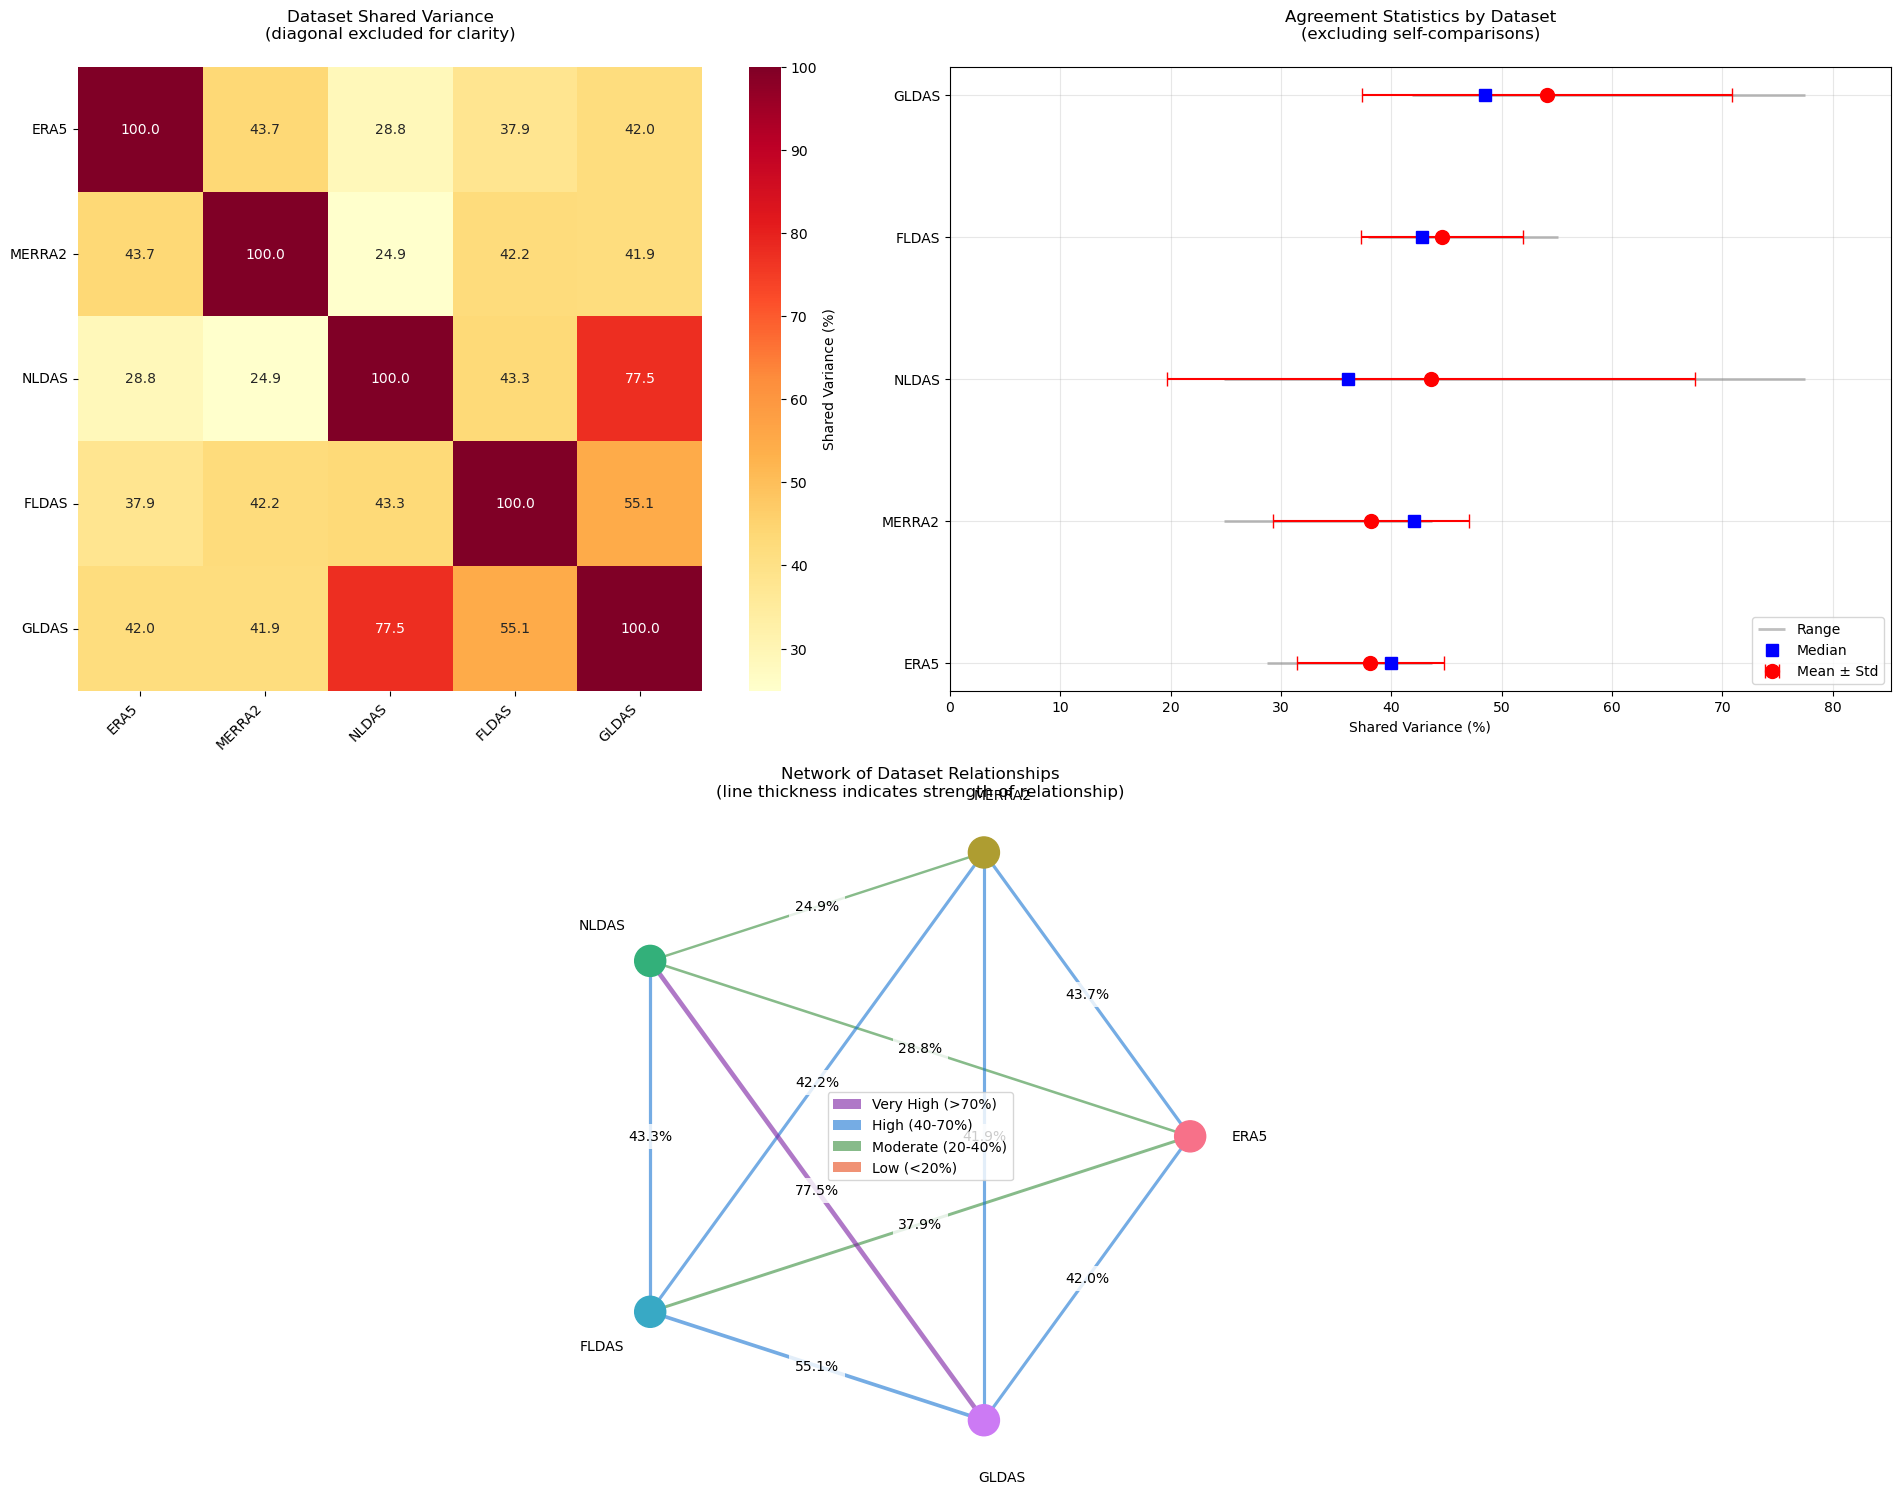


Detailed Statistical Summary:

ERA5:
  Range: 28.8% - 43.7%
  Mean ± Std: 38.1% ± 6.7%
  Median: 39.9%
  Most similar to: MERRA2 (43.7%)
  Least similar to: NLDAS (28.8%)

MERRA2:
  Range: 24.9% - 43.7%
  Mean ± Std: 38.2% ± 8.9%
  Median: 42.1%
  Most similar to: ERA5 (43.7%)
  Least similar to: NLDAS (24.9%)

NLDAS:
  Range: 24.9% - 77.5%
  Mean ± Std: 43.6% ± 23.9%
  Median: 36.1%
  Most similar to: GLDAS (77.5%)
  Least similar to: MERRA2 (24.9%)

FLDAS:
  Range: 37.9% - 55.1%
  Mean ± Std: 44.6% ± 7.3%
  Median: 42.8%
  Most similar to: GLDAS (55.1%)
  Least similar to: ERA5 (37.9%)

GLDAS:
  Range: 41.9% - 77.5%
  Mean ± Std: 54.1% ± 16.8%
  Median: 48.5%
  Most similar to: NLDAS (77.5%)
  Least similar to: MERRA2 (41.9%)


In [ ]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from matplotlib.patches import Patch

def create_additional_visualizations(shared_variance_matrix):
    """
    Create additional visualizations to analyze soil moisture dataset relationships.
    """
    fig = plt.figure(figsize=(20, 15))
    gs = plt.GridSpec(2, 2, figure=fig)
    
    # 1. Enhanced Heatmap with Dataset Grouping
    ax1 = fig.add_subplot(gs[0, 0])
    
    # Create mask for diagonal
    mask = np.zeros_like(shared_variance_matrix, dtype=bool)
    #np.fill_diagonal(mask, True)
    
    # Plot heatmap
    sns.heatmap(shared_variance_matrix,
                annot=True,
                fmt='.1f',
                cmap='YlOrRd',
                mask=mask,  # Mask diagonal
                square=True,
                ax=ax1,
                cbar_kws={'label': 'Shared Variance (%)'})
    
    ax1.set_title('Dataset Shared Variance\n(diagonal excluded for clarity)', pad=20)
    # Rotate labels for better readability
    ax1.set_xticklabels(ax1.get_xticklabels(), rotation=45, ha='right')
    ax1.set_yticklabels(ax1.get_yticklabels(), rotation=0)
    
    # 2. Agreement Range Plot
    ax2 = fig.add_subplot(gs[0, 1])
    
    # Calculate statistics for each dataset
    stats = []
    for dataset in shared_variance_matrix.index:
        values = shared_variance_matrix.loc[dataset]
        values = values[values != 100]  # Remove self-comparison
        stats.append({
            'Dataset': dataset,
            'Min': values.min(),
            'Max': values.max(),
            'Mean': values.mean(),
            'Median': values.median(),
            'Std': values.std()
        })
    
    stats_df = pd.DataFrame(stats).sort_values('Mean', ascending=True)
    
    # Plot ranges with error bars
    y_pos = np.arange(len(stats_df))
    ax2.hlines(y_pos, stats_df['Min'], stats_df['Max'], 
               color='gray', alpha=0.5, linewidth=2, label='Range')
    
    # Add mean points with std error bars
    ax2.errorbar(stats_df['Mean'], y_pos, 
                xerr=stats_df['Std'],
                fmt='ro', markersize=10, 
                label='Mean ± Std',
                capsize=5)
    
    # Add median points
    ax2.plot(stats_df['Median'], y_pos, 'bs', 
             label='Median', markersize=8)
    
    # Add dataset labels and formatting
    ax2.set_yticks(y_pos)
    ax2.set_yticklabels(stats_df['Dataset'])
    ax2.set_xlabel('Shared Variance (%)')
    ax2.set_title('Agreement Statistics by Dataset\n(excluding self-comparisons)', pad=20)
    ax2.grid(True, alpha=0.3)
    ax2.legend(loc='lower right')
    
    # Set x-axis limits with padding
    ax2.set_xlim(0, max(stats_df['Max']) * 1.1)
    
    # 3. Network Plot with Agreement Categories
    ax3 = fig.add_subplot(gs[1, :])
    
    def create_categorical_network(variance_matrix, ax):
        n_datasets = len(variance_matrix)
        angles = np.linspace(0, 2*np.pi, n_datasets, endpoint=False)
        
        # Define agreement categories with distinct colors
        categories = {
            'Very High (>70%)': (70, 100, '#7b1fa2'),  # Purple
            'High (40-70%)': (40, 70, '#1976d2'),      # Blue
            'Moderate (20-40%)': (20, 40, '#388e3c'),  # Green
            'Low (<20%)': (0, 20, '#e64a19')          # Orange
        }
        
        # Calculate node positions
        radius = 1
        x = radius * np.cos(angles)
        y = radius * np.sin(angles)
        
        # Create legend elements
        legend_elements = []
        for cat, (min_val, max_val, color) in categories.items():
            legend_elements.append(
                Patch(facecolor=color, alpha=0.6, label=cat)
            )
        
        # Plot connections
        for i in range(n_datasets):
            for j in range(i+1, n_datasets):
                value = variance_matrix.iloc[i,j]
                if not np.isnan(value) and i != j:  # Exclude self-connections
                    # Determine category
                    for cat, (min_val, max_val, color) in categories.items():
                        if min_val <= value < max_val:
                            break
                            
                    # Draw connection with varying thickness based on value
                    thickness = 1 + 3 * (value / 100)  # Scale 1-4 based on value
                    ax.plot([x[i], x[j]], [y[i], y[j]], 
                           linewidth=thickness,
                           alpha=0.6,
                           color=color,
                           zorder=1)
                    
                    # Add value label
                    mid_x = (x[i] + x[j]) / 2
                    mid_y = (y[i] + y[j]) / 2
                    ax.text(mid_x, mid_y,
                           f'{value:.1f}%',
                           ha='center', va='center',
                           bbox=dict(facecolor='white',
                                   edgecolor='none',
                                   alpha=0.8))
        
        # Plot nodes
        colors = sns.color_palette("husl", n_datasets)
        ax.scatter(x, y, s=500, c=colors, zorder=2)
        
        # Add dataset labels
        for i, label in enumerate(variance_matrix.index):
            ax.text(1.2*x[i], 1.2*y[i], label,
                   ha='center', va='center',
                   bbox=dict(facecolor='white',
                           edgecolor='none',
                           alpha=0.8))
        
        ax.set_aspect('equal')
        ax.axis('off')
        ax.legend(handles=legend_elements, loc='center')
        ax.set_title('Network of Dataset Relationships\n(line thickness indicates strength of relationship)', pad=20)
    
    create_categorical_network(shared_variance_matrix, ax3)
    
    plt.tight_layout()
    return fig

# Create the visualizations
fig = create_additional_visualizations(shared_variance_matrix)
plt.show()

# Print enhanced statistical summary
print("\nDetailed Statistical Summary:")
for dataset in shared_variance_matrix.index:
    values = shared_variance_matrix.loc[dataset]
    values = values[values != 100]  # Remove self-comparison
    print(f"\n{dataset}:")
    print(f"  Range: {values.min():.1f}% - {values.max():.1f}%")
    print(f"  Mean ± Std: {values.mean():.1f}% ± {values.std():.1f}%")
    print(f"  Median: {values.median():.1f}%")
    print(f"  Most similar to: {values.idxmax()} ({values.max():.1f}%)")
    print(f"  Least similar to: {values.idxmin()} ({values.min():.1f}%)")

                    Spatial mapping                     



MERRA2 shape: (132, 10, 13)

NLDAS shape: (132, 36, 63)

FLDAS shape: (132, 45, 79)

GLDAS shape: (132, 18, 32)

ERA5 shape: (132, 46, 80)

Using minimum dimensions: lat=10, lon=13

Spatial Agreement Summary Statistics:

Overall Agreement Metrics:
Best agreement:  (r=-inf)
Worst agreement: ERA5-FLDAS (r=-0.000)

Detailed Statistics:

Metric               Mean       Median     Min        Max        Std        Valid N   
--------------------------------------------------------------------------------
Mean Correlation     0.499      0.500      0.368      0.634      0.049      130       
Max Correlation      0.829      0.830      0.718      0.893      0.036      130       
Min Correlation      0.167      0.185      -0.049     0.407      0.101      130       
Correlation Std      0.201      0.188      0.130      0.360      0.049      130       


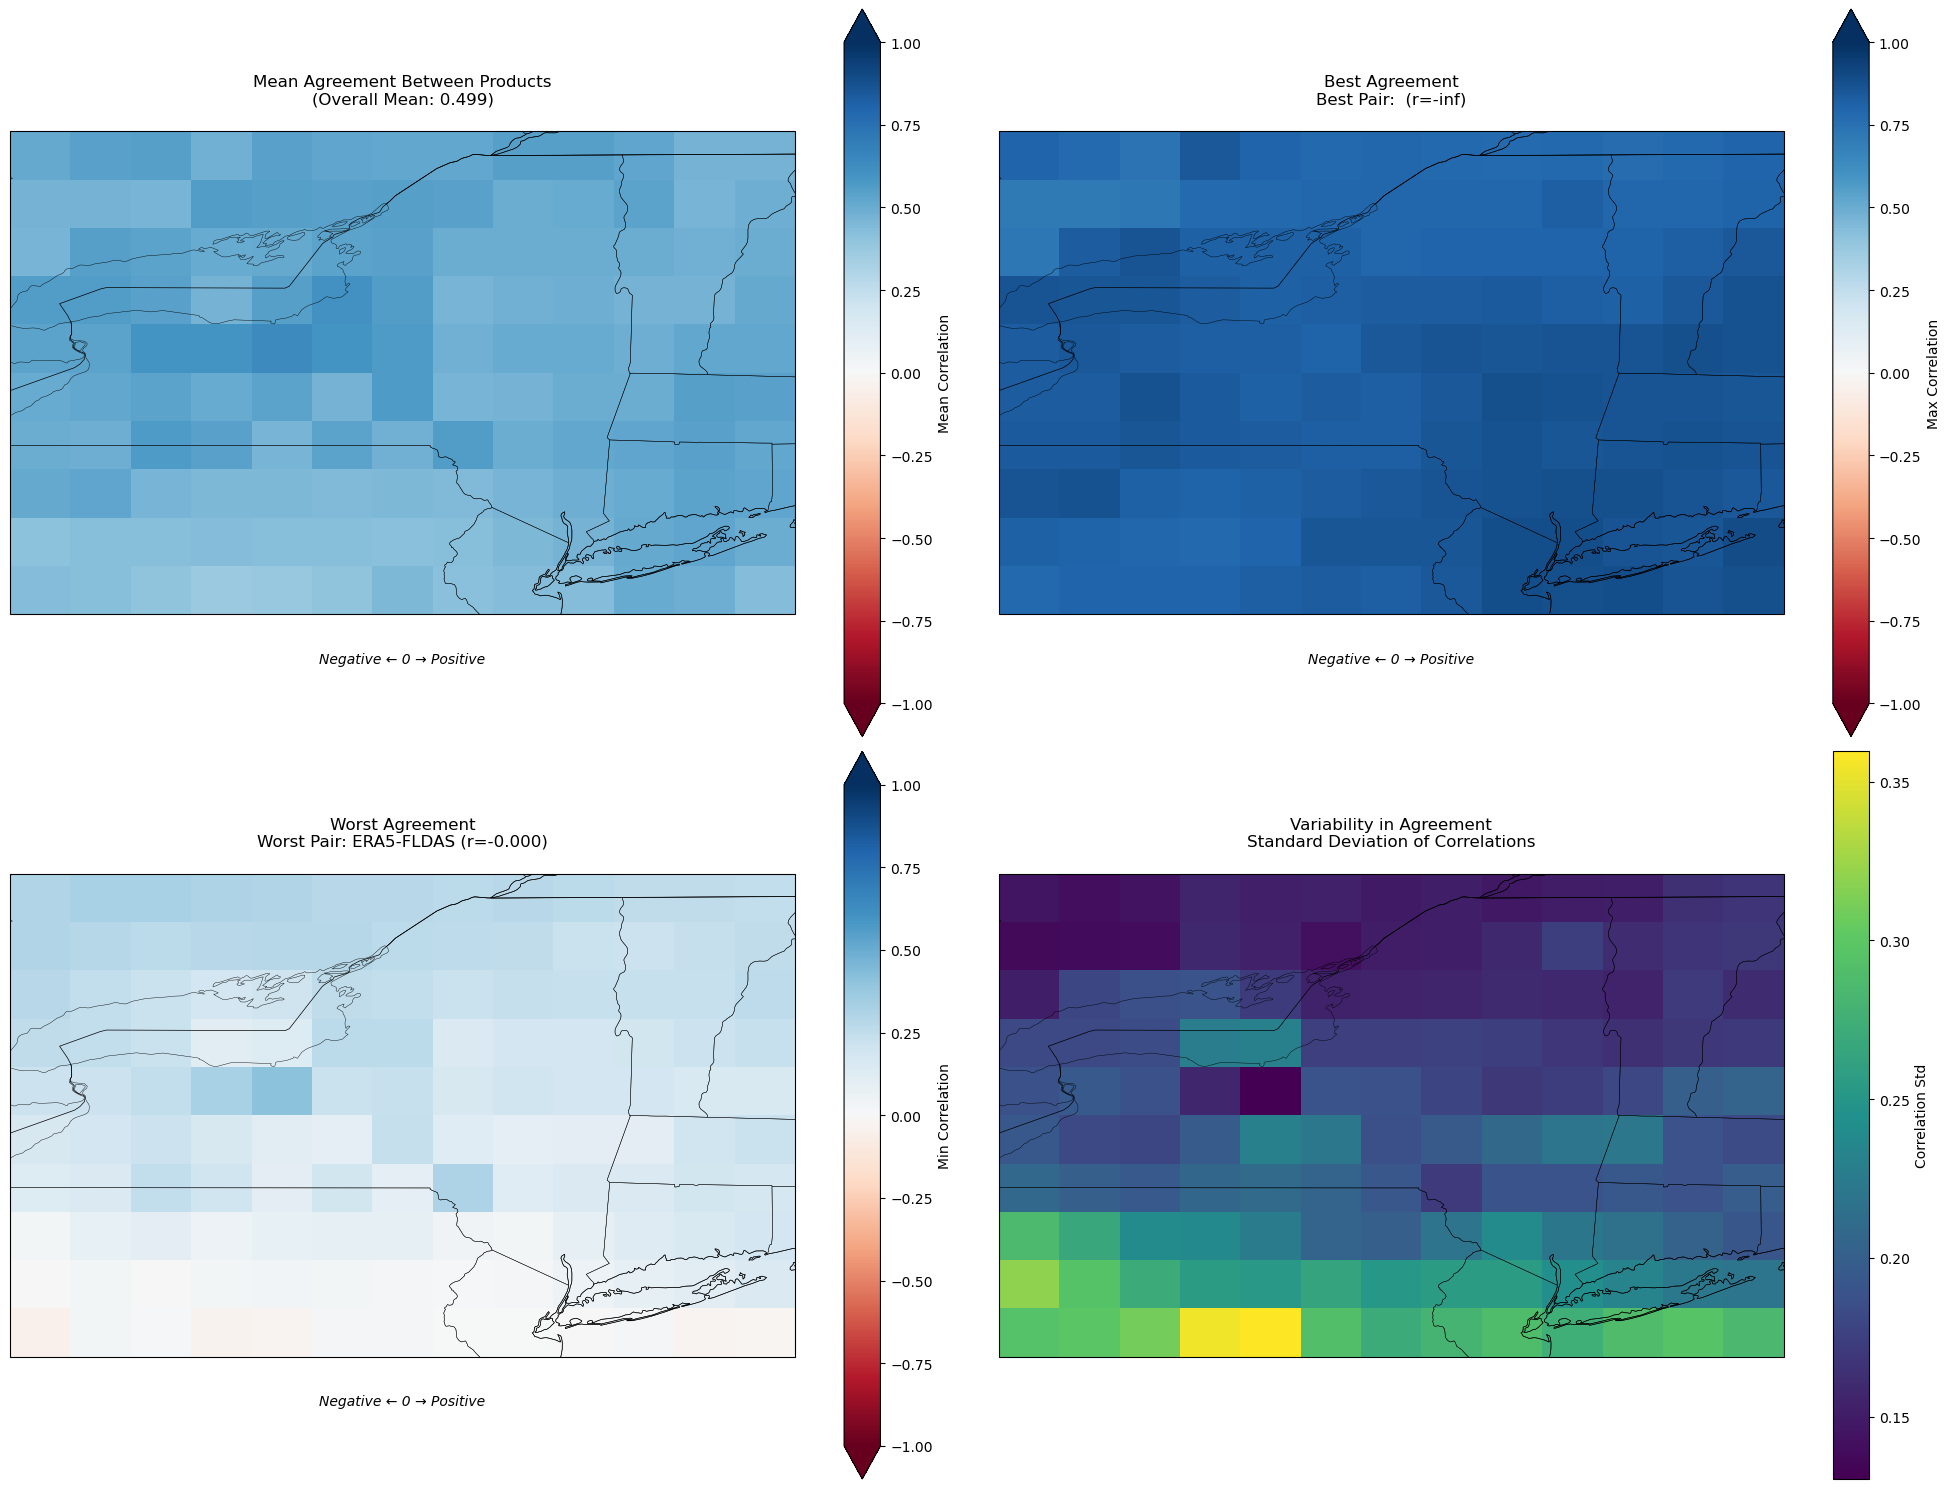

In [ ]:
import xarray as xr
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.colors import LinearSegmentedColormap
import cartopy.crs as ccrs
import cartopy.feature as cfeature

def calculate_spatial_agreement(datasets_dict):
    """Calculate spatial correlation and agreement metrics"""
    
    # First preprocess all datasets and store product pairs with their correlations
    processed_data = {}
    
    for name, data in datasets_dict.items():
        if isinstance(data, xr.Dataset):
            if name == 'MERRA2' and 'SFMC' in data:
                processed_data[name] = data['SFMC']
            elif name == 'NLDAS' and 'SoilM_0_10cm' in data:
                processed_data[name] = data['SoilM_0_10cm']
            elif name == 'FLDAS' and 'SoilMoi00_10cm_tavg' in data:
                processed_data[name] = data['SoilMoi00_10cm_tavg']
            elif name == 'GLDAS' and 'SoilMoi0_10cm_inst' in data:
                processed_data[name] = data['SoilMoi0_10cm_inst']
            elif name == 'ERA5' and 'swvl1' in data:
                processed_data[name] = data['swvl1']
        else:
            processed_data[name] = data
        
        print(f"\n{name} shape:", processed_data[name].shape)
    
    # Find minimum dimensions across all datasets
    min_lat = min(data.shape[1] for data in processed_data.values())
    min_lon = min(data.shape[2] for data in processed_data.values())
    print(f"\nUsing minimum dimensions: lat={min_lat}, lon={min_lon}")
    
    # Initialize result arrays with NaN
    mean_correlation = np.full((min_lat, min_lon), np.nan)
    max_correlation = np.full((min_lat, min_lon), np.nan)
    min_correlation = np.full((min_lat, min_lon), np.nan)
    correlation_std = np.full((min_lat, min_lon), np.nan)
    
    # Track best and worst product pairs
    best_pairs = np.empty((min_lat, min_lon), dtype='U20')
    worst_pairs = np.empty((min_lat, min_lon), dtype='U20')
    
    # Initialize with infinity for proper min/max finding
    overall_best_corr = -np.inf
    overall_worst_corr = np.inf
    overall_best_pair = ""
    overall_worst_pair = ""
    
    # Calculate correlations
    for i in range(min_lat):
        for j in range(min_lon):
            correlations = []
            pairs = []
            
            for name1, data1 in processed_data.items():
                for name2, data2 in processed_data.items():
                    if name1 < name2:  # Avoid duplicate comparisons
                        try:
                            # Extract time series at this location
                            ts1 = data1[:, i, j]
                            ts2 = data2[:, i, j]
                            
                            # Calculate correlation
                            d1 = ts1.values if hasattr(ts1, 'values') else ts1
                            d2 = ts2.values if hasattr(ts2, 'values') else ts2
                            
                            valid_mask = ~(np.isnan(d1) | np.isnan(d2))
                            if valid_mask.any():
                                d1_valid = d1[valid_mask]
                                d2_valid = d2[valid_mask]
                                
                                if len(d1_valid) >= 2:
                                    corr = np.corrcoef(d1_valid, d2_valid)[0,1]
                                    if not np.isnan(corr):
                                        correlations.append(corr)
                                        pair = f"{name1}-{name2}"
                                        pairs.append(pair)
                                        
                                        # Update overall metrics based on absolute correlation
                                        abs_corr = abs(corr)
                                        if abs_corr > abs(overall_best_corr):
                                            overall_best_corr = corr
                                            overall_best_pair = pair
                                        if abs_corr < abs(overall_worst_corr):
                                            overall_worst_corr = corr
                                            overall_worst_pair = pair
                                        
                        except Exception as e:
                            print(f"Error at ({i},{j}) between {name1}-{name2}: {str(e)}")
            
            if correlations:
                mean_correlation[i,j] = np.mean(correlations)
                abs_corr = np.abs(correlations)
                max_idx = np.argmax(abs_corr)
                min_idx = np.argmin(abs_corr)
                max_correlation[i,j] = correlations[max_idx]
                min_correlation[i,j] = correlations[min_idx]
                correlation_std[i,j] = np.std(correlations)
                best_pairs[i,j] = pairs[max_idx]
                worst_pairs[i,j] = pairs[min_idx]
    
    # Get coordinate values
    ref_data = processed_data['MERRA2']
    try:
        lats = ref_data.lat.values[:min_lat]
        lons = ref_data.lon.values[:min_lon]
    except AttributeError:
        try:
            lats = ref_data.latitude.values[:min_lat]
            lons = ref_data.longitude.values[:min_lon]
        except AttributeError:
            lats = np.arange(min_lat)
            lons = np.arange(min_lon)
    
    return {
        'mean_correlation': xr.DataArray(
            mean_correlation,
            coords={'latitude': lats, 'longitude': lons},
            dims=['latitude', 'longitude']
        ),
        'max_correlation': xr.DataArray(
            max_correlation,
            coords={'latitude': lats, 'longitude': lons},
            dims=['latitude', 'longitude']
        ),
        'min_correlation': xr.DataArray(
            min_correlation,
            coords={'latitude': lats, 'longitude': lons},
            dims=['latitude', 'longitude']
        ),
        'correlation_std': xr.DataArray(
            correlation_std,
            coords={'latitude': lats, 'longitude': lons},
            dims=['latitude', 'longitude']
        ),
        'best_pair': overall_best_pair,
        'worst_pair': overall_worst_pair,
        'best_corr': overall_best_corr,
        'worst_corr': overall_worst_corr
    }

def plot_agreement_maps(spatial_metrics):
    """Create enhanced maps showing spatial patterns of agreement"""
    fig = plt.figure(figsize=(20, 15))
    
    # Create diverging colormap for correlations
    correlation_cmap = LinearSegmentedColormap.from_list('correlation', [
        '#67001f',  # Dark red (negative correlations)
        '#b2182b',
        '#d6604d',
        '#f4a582',
        '#fddbc7',
        '#f7f7f7',  # White (zero correlation)
        '#d1e5f0',
        '#92c5de',
        '#4393c3',
        '#2166ac',
        '#053061'   # Dark blue (positive correlations)
    ])
    
    # Create custom colormap for variability
    variability_cmap = LinearSegmentedColormap.from_list('variability', [
        '#440154', '#3b528b', '#21918c', '#5ec962', '#fde725'
    ])
    
    # Setup projections
    proj = ccrs.PlateCarree()
    
    # Calculate overall statistics for mean correlation
    mean_corr = spatial_metrics['mean_correlation'].values
    valid_mask = ~np.isnan(mean_corr)
    if valid_mask.any():
        overall_mean = np.mean(mean_corr[valid_mask])
    else:
        overall_mean = np.nan
    
    titles = {
        'mean_correlation': f'Mean Agreement Between Products\n(Overall Mean: {overall_mean:.3f})',
        'max_correlation': f'Best Agreement\nBest Pair: {spatial_metrics["best_pair"]} (r={spatial_metrics["best_corr"]:.3f})',
        'min_correlation': f'Worst Agreement\nWorst Pair: {spatial_metrics["worst_pair"]} (r={spatial_metrics["worst_corr"]:.3f})',
        'correlation_std': 'Variability in Agreement\nStandard Deviation of Correlations'
    }
    
    metrics_to_plot = ['mean_correlation', 'max_correlation', 'min_correlation', 'correlation_std']
    
    for idx, metric_name in enumerate(metrics_to_plot, 1):
        ax = fig.add_subplot(2, 2, idx, projection=proj)
        data = spatial_metrics[metric_name]
        
        if metric_name == 'correlation_std':
            plot_cmap = variability_cmap
            vmin = None
            vmax = None
            extend = 'neither'
        else:
            plot_cmap = correlation_cmap
            vmin = -1
            vmax = 1
            extend = 'both'
        
        # Plot data
        img = data.plot(
            ax=ax,
            transform=proj,
            cmap=plot_cmap,
            vmin=vmin,
            vmax=vmax,
            cbar_kwargs={
                'label': metric_name.replace('_', ' ').title(),
                'extend': extend
            }
        )
        
        # Add map features
        ax.coastlines(linewidth=0.5)
        ax.add_feature(cfeature.STATES, linewidth=0.3)
        ax.add_feature(cfeature.BORDERS, linewidth=0.5)
        
        # Improve title appearance
        ax.set_title(titles[metric_name], pad=20, fontsize=12)
        
        # Add explanation for correlation plots
        if metric_name != 'correlation_std':
            ax.text(0.5, -0.1, 'Negative ← 0 → Positive', 
                   transform=ax.transAxes, ha='center', 
                   fontsize=10, style='italic')
    
    plt.tight_layout()
    return fig

def print_enhanced_statistics(spatial_metrics):
    """Print comprehensive statistics about spatial agreement"""
    print("\nSpatial Agreement Summary Statistics:")
    print("\nOverall Agreement Metrics:")
    print(f"Best agreement: {spatial_metrics['best_pair']} (r={spatial_metrics['best_corr']:.3f})")
    print(f"Worst agreement: {spatial_metrics['worst_pair']} (r={spatial_metrics['worst_corr']:.3f})")
    
    metrics = ['mean_correlation', 'max_correlation', 'min_correlation', 'correlation_std']
    
    print("\nDetailed Statistics:")
    print("\n{:<20} {:<10} {:<10} {:<10} {:<10} {:<10} {:<10}".format(
        "Metric", "Mean", "Median", "Min", "Max", "Std", "Valid N"
    ))
    print("-" * 80)
    
    for metric_name in metrics:
        metric_data = spatial_metrics[metric_name]
        valid_data = metric_data.values[~np.isnan(metric_data.values)]
        
        if len(valid_data) > 0:
            print("{:<20} {:<10.3f} {:<10.3f} {:<10.3f} {:<10.3f} {:<10.3f} {:<10d}".format(
                metric_name.replace('_', ' ').title(),
                np.mean(valid_data),
                np.median(valid_data),
                np.min(valid_data),
                np.max(valid_data),
                np.std(valid_data),
                len(valid_data)
            ))

# Example usage:
spatial_metrics = calculate_spatial_agreement(datasets)
fig = plot_agreement_maps(spatial_metrics)
print_enhanced_statistics(spatial_metrics)
plt.show()


Decomposed MERRA2 into seasons

Decomposed NLDAS into seasons

Decomposed FLDAS into seasons

Decomposed GLDAS into seasons

Decomposed ERA5 into seasons

Processing Winter

Processing Spring

Processing Summer

Processing Fall


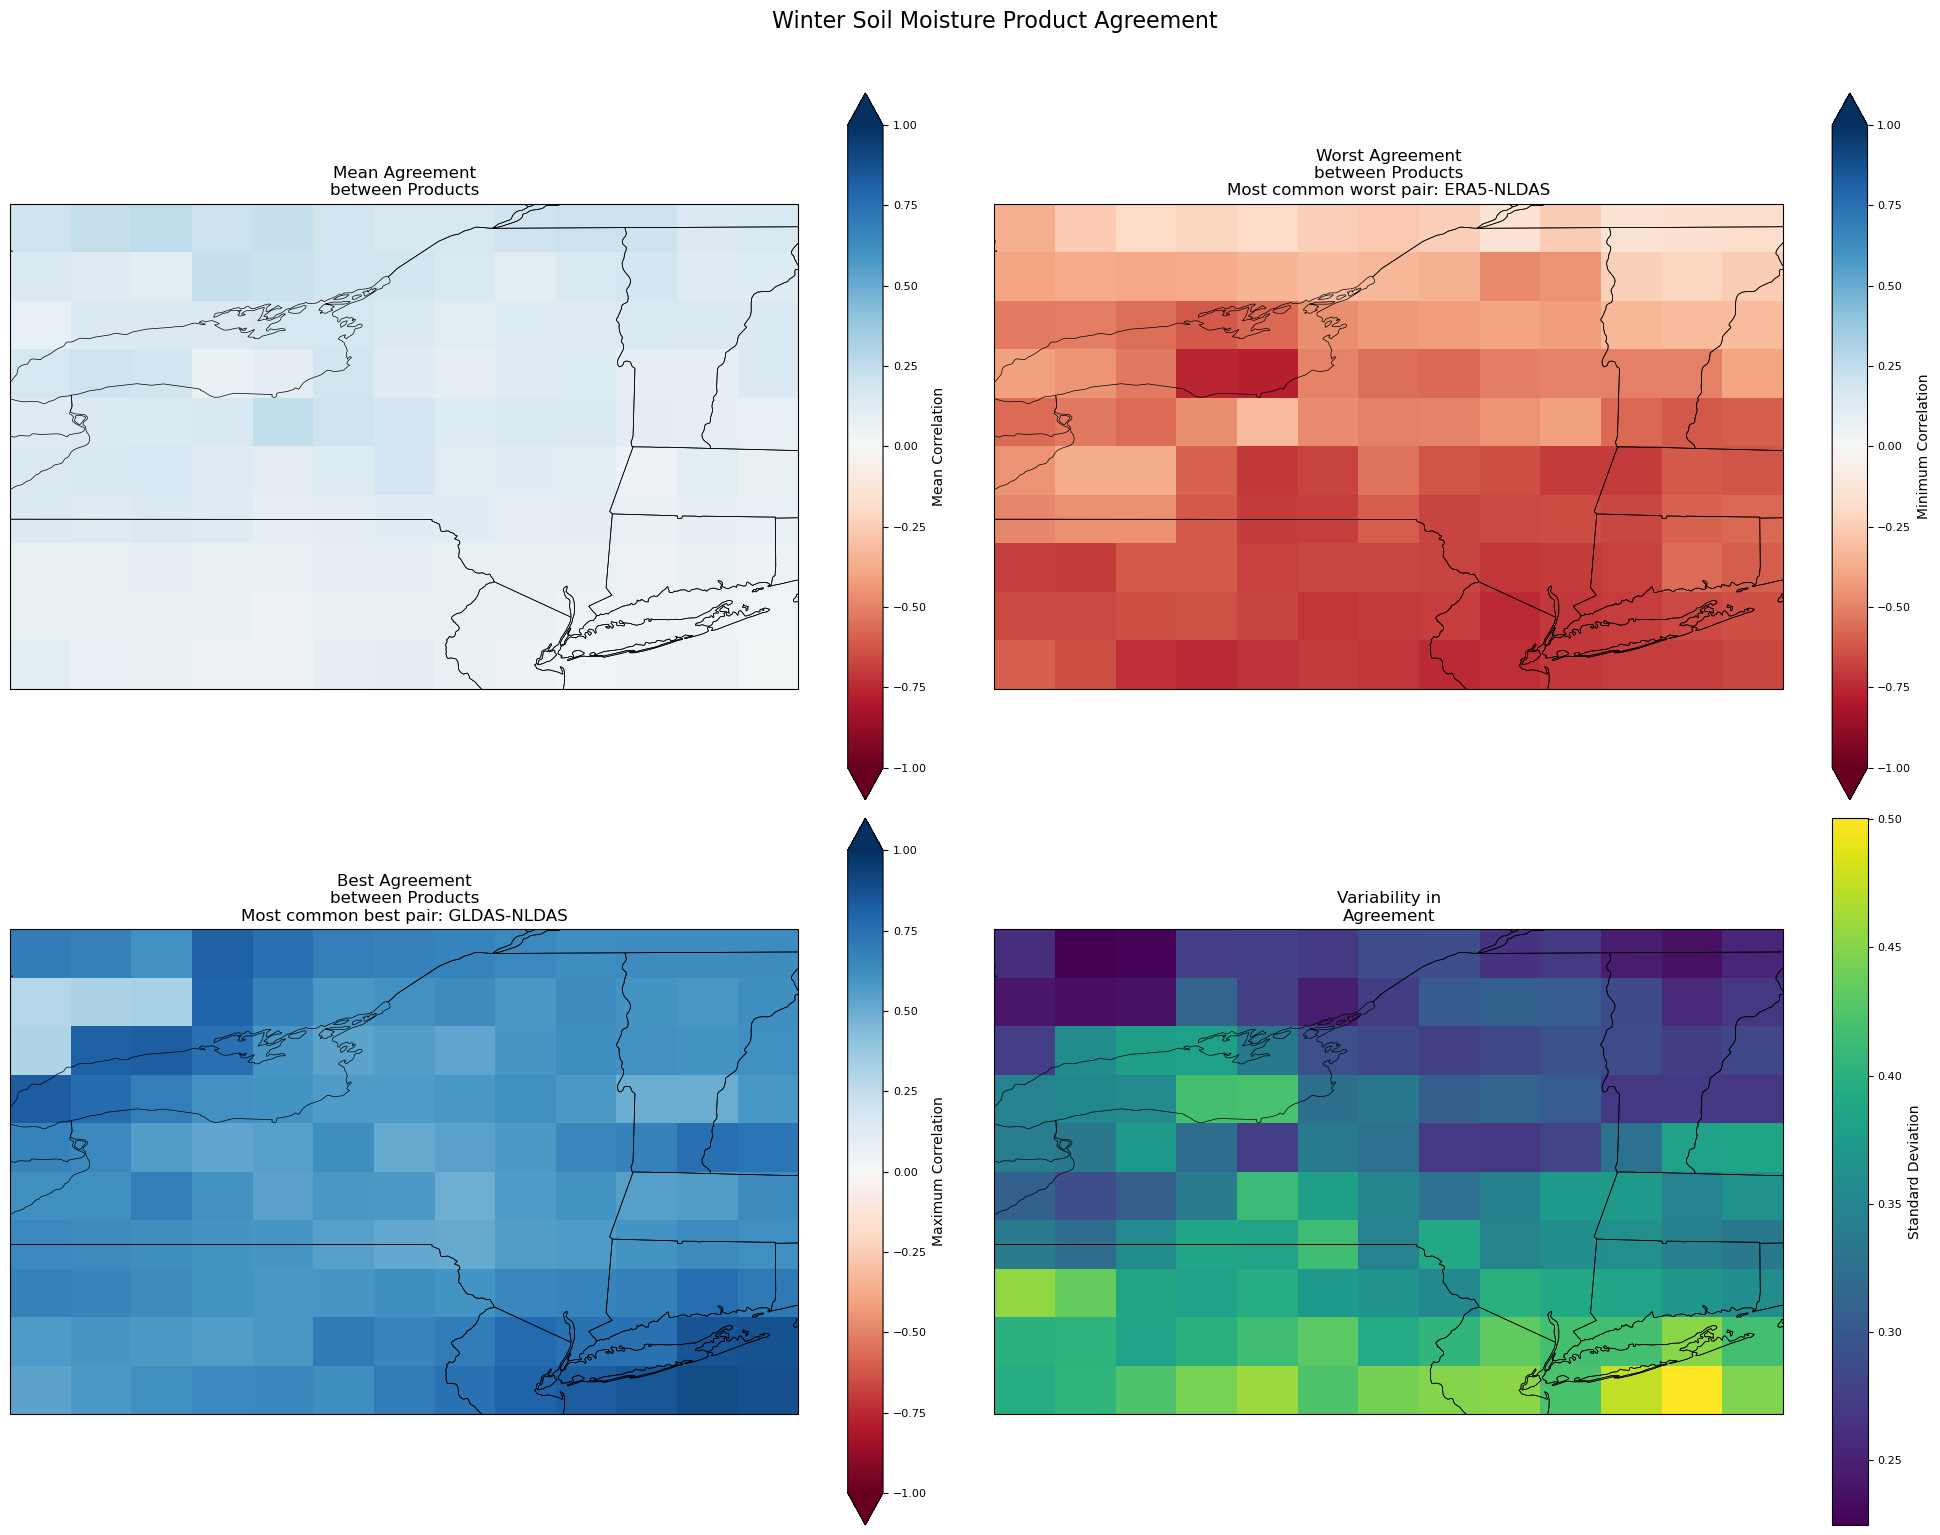


=== Winter Statistics ===

mean_correlation:
Mean: 0.123
Median: 0.118
Min: 0.030
Max: 0.256

max_correlation:
Mean: 0.630
Median: 0.614
Min: 0.296
Max: 0.891

min_correlation:
Mean: -0.529
Median: -0.570
Min: -0.775
Max: -0.145

correlation_std:
Mean: 0.345
Median: 0.347
Min: 0.225
Max: 0.500


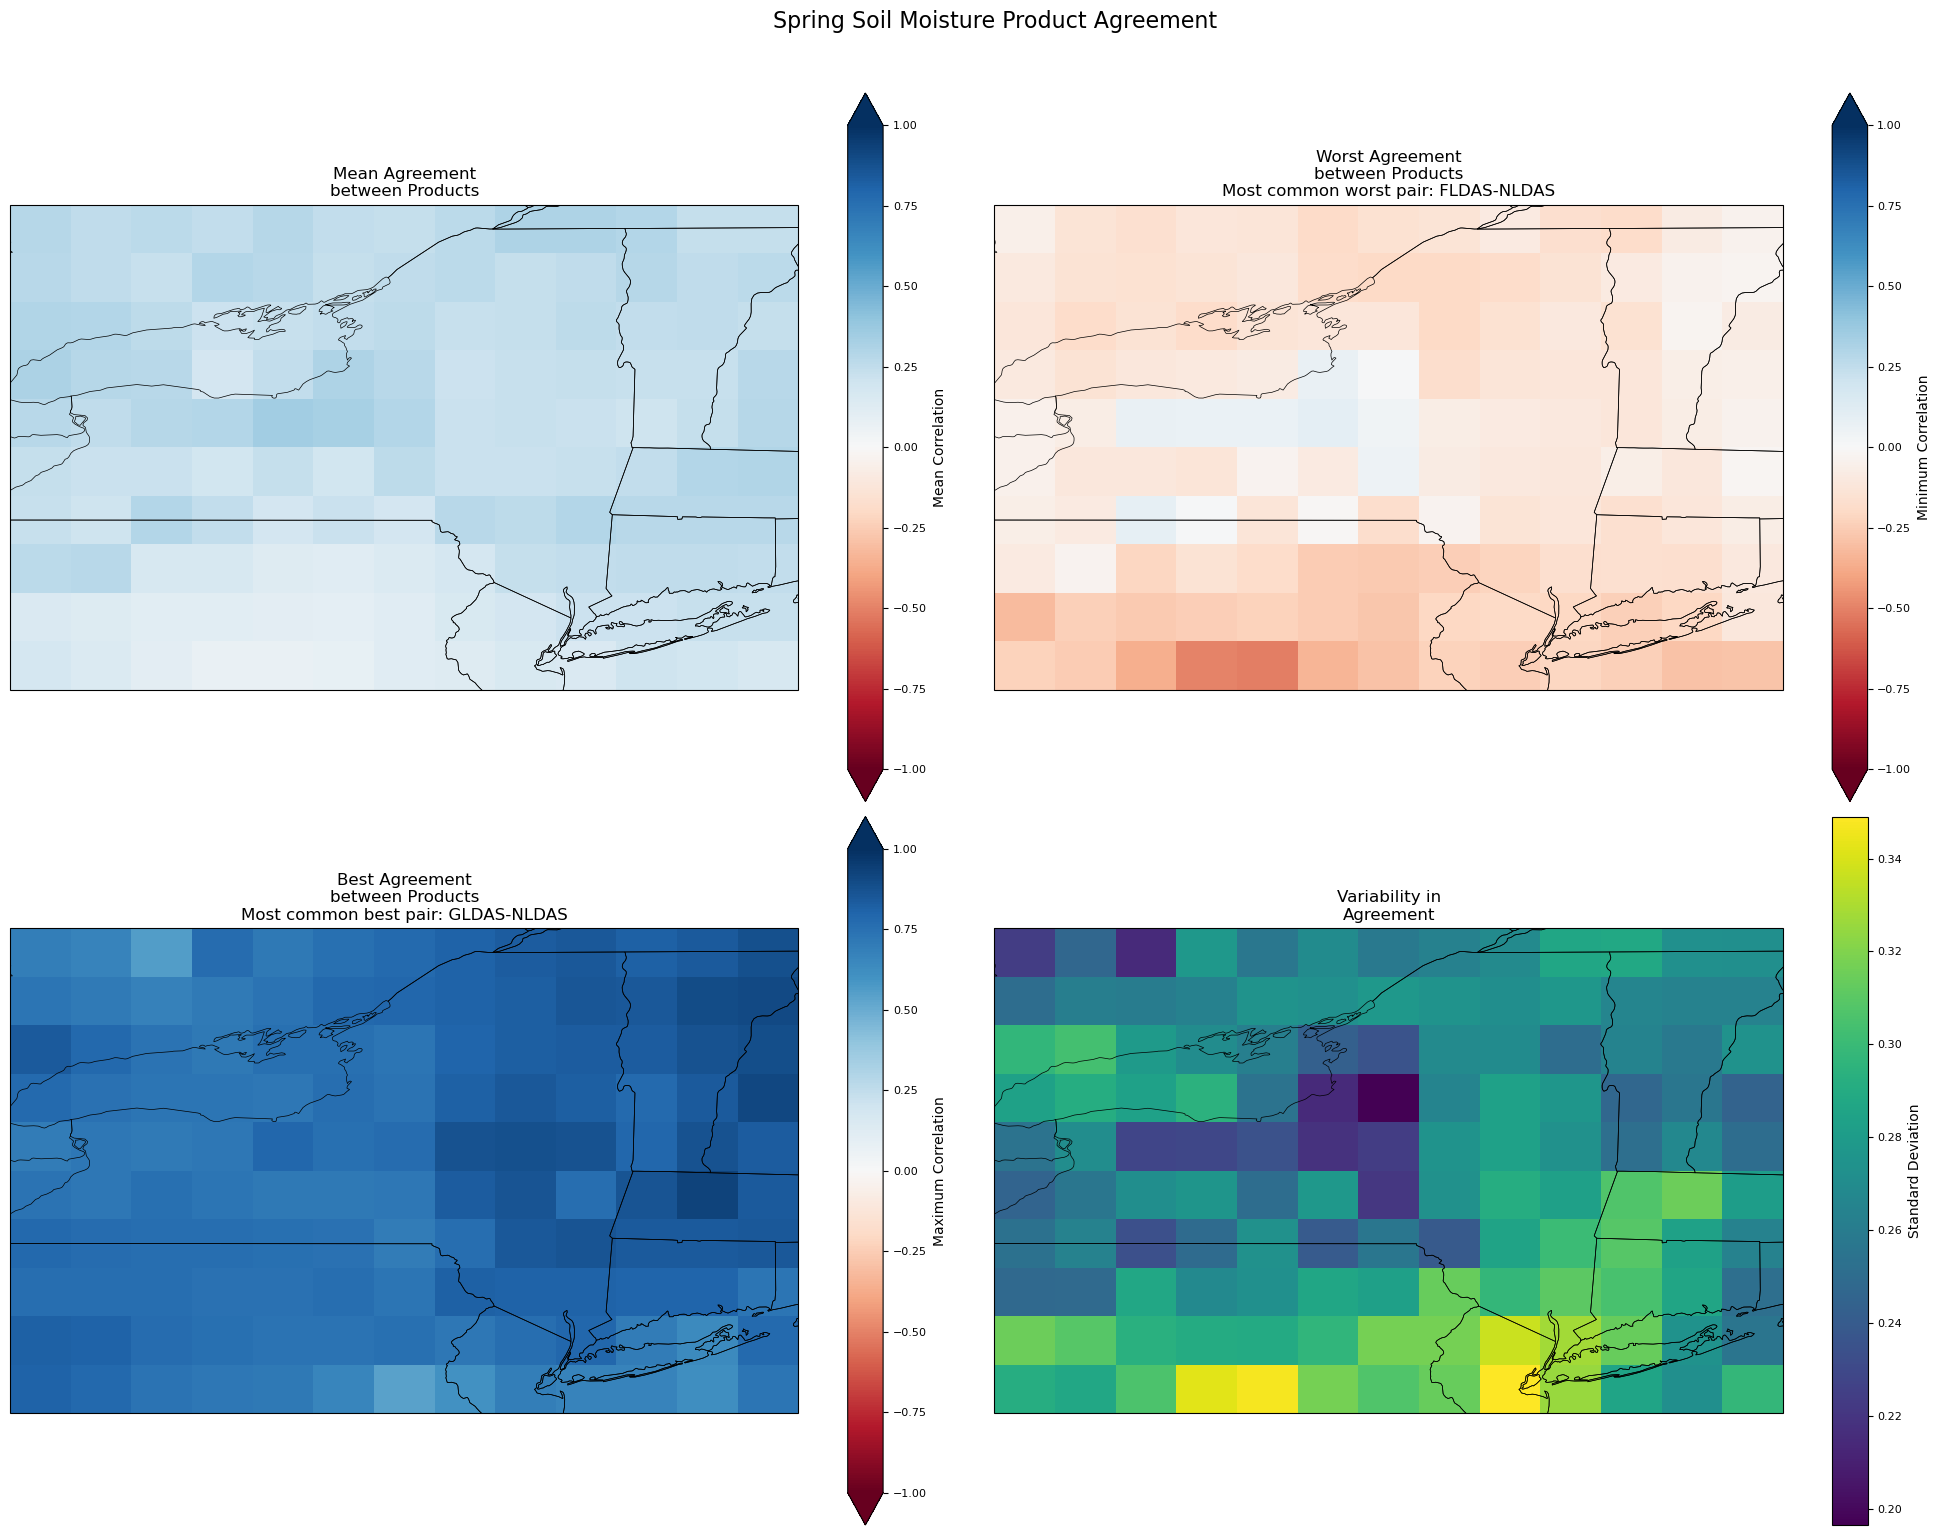


=== Spring Statistics ===

mean_correlation:
Mean: 0.229
Median: 0.241
Min: 0.071
Max: 0.349

max_correlation:
Mean: 0.772
Median: 0.763
Min: 0.539
Max: 0.924

min_correlation:
Mean: -0.136
Median: -0.127
Min: -0.511
Max: 0.095

correlation_std:
Mean: 0.274
Median: 0.273
Min: 0.196
Max: 0.349


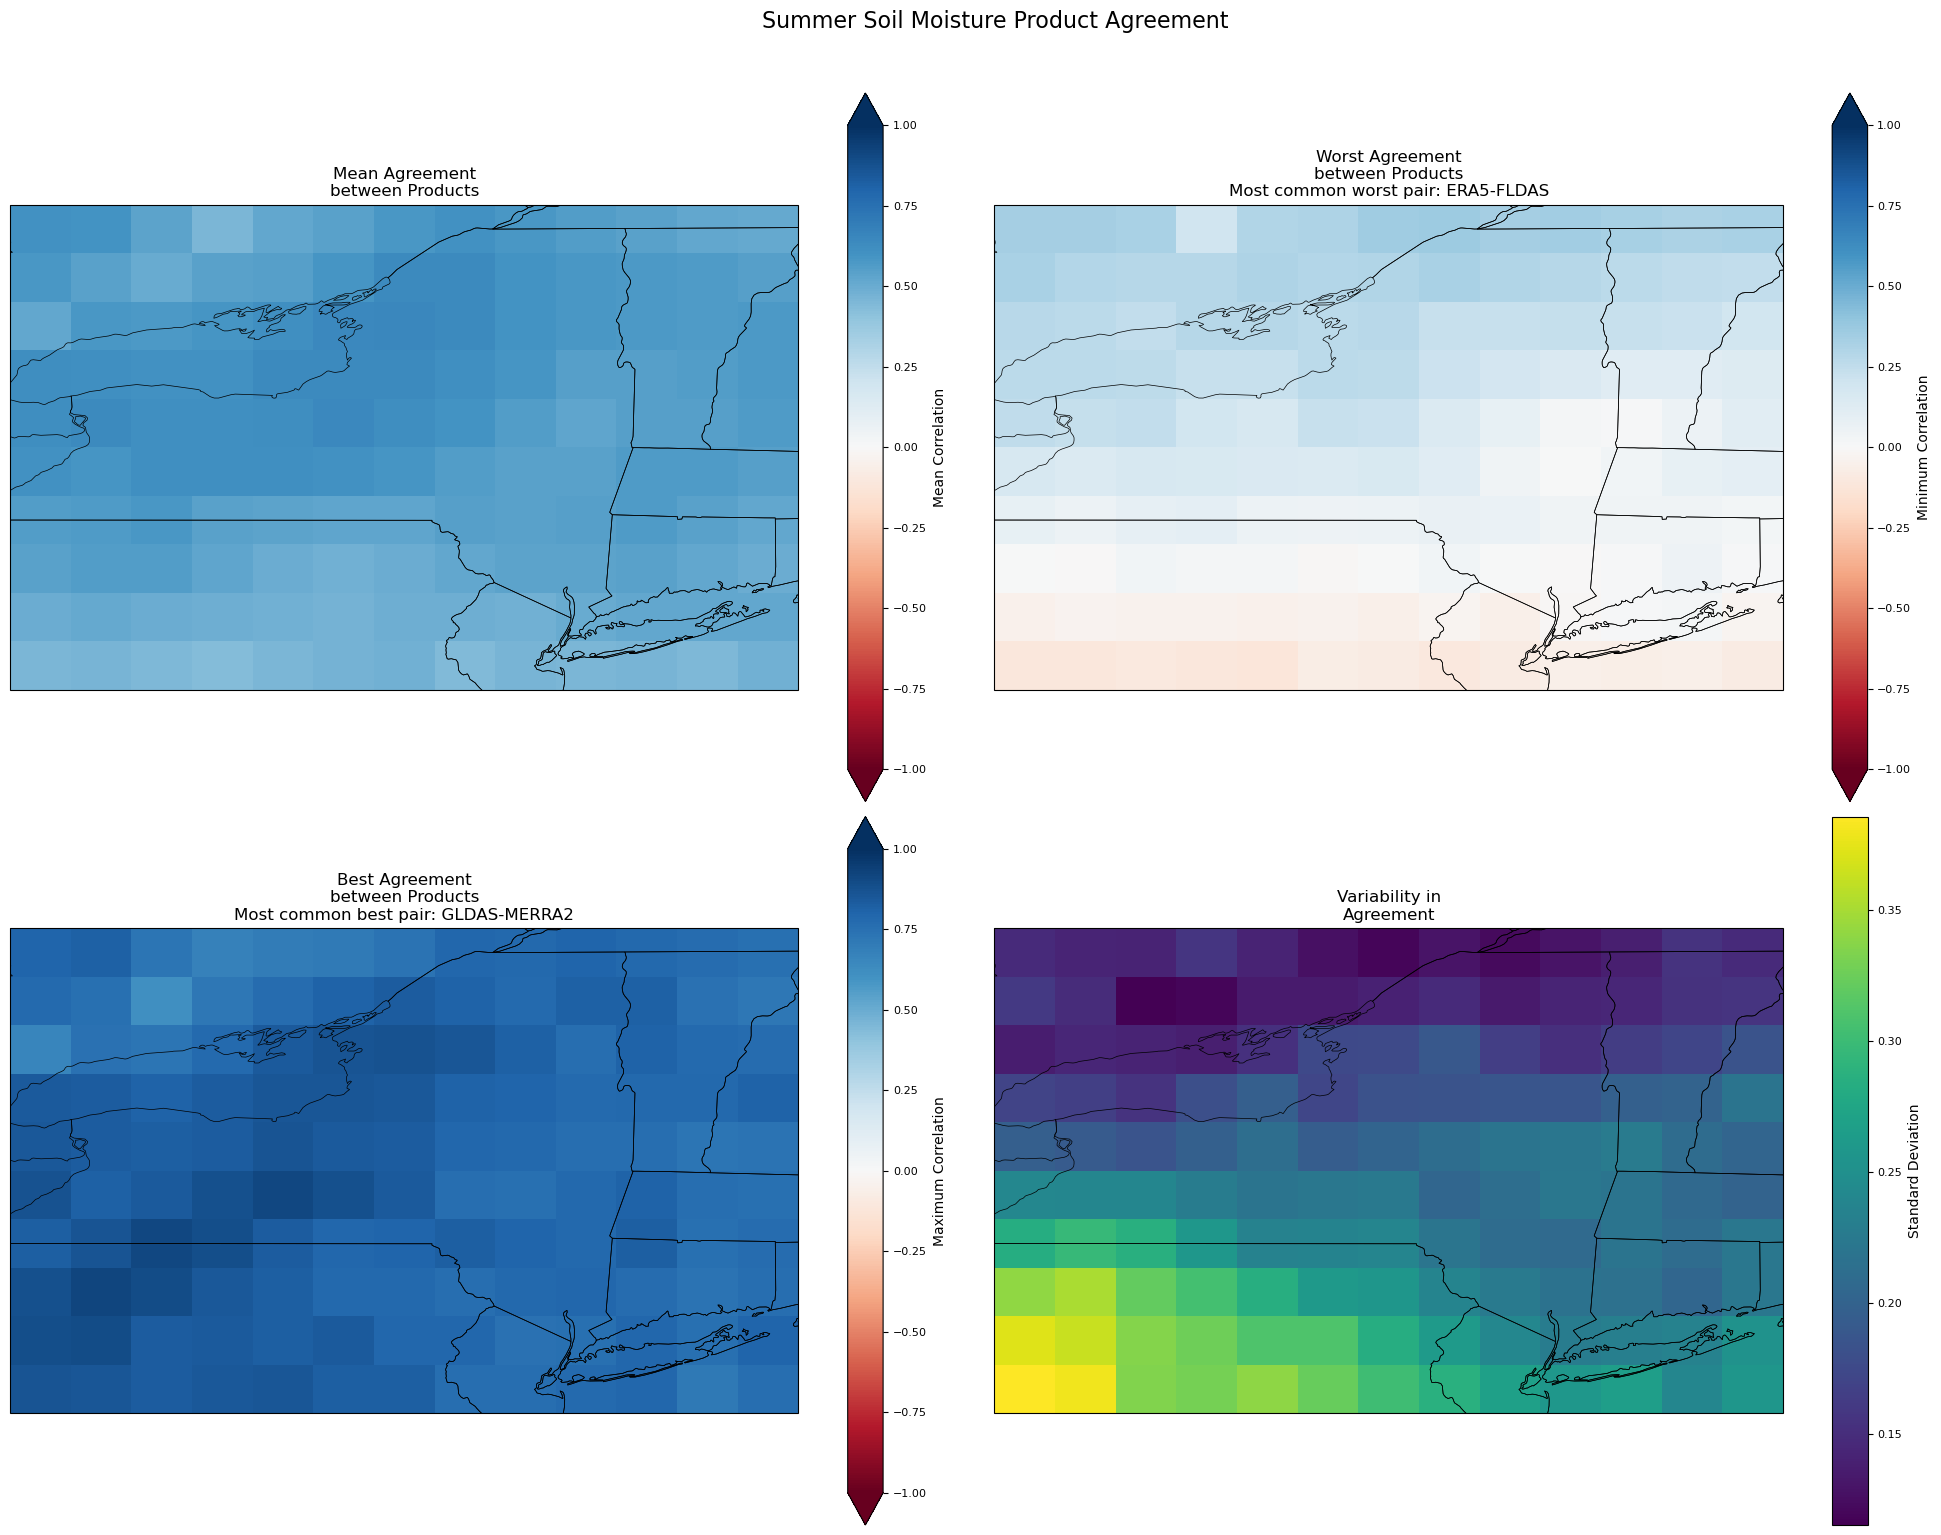


=== Summer Statistics ===

mean_correlation:
Mean: 0.552
Median: 0.553
Min: 0.432
Max: 0.650

max_correlation:
Mean: 0.801
Median: 0.799
Min: 0.613
Max: 0.921

min_correlation:
Mean: 0.129
Median: 0.128
Min: -0.118
Max: 0.360

correlation_std:
Mean: 0.215
Median: 0.210
Min: 0.115
Max: 0.385


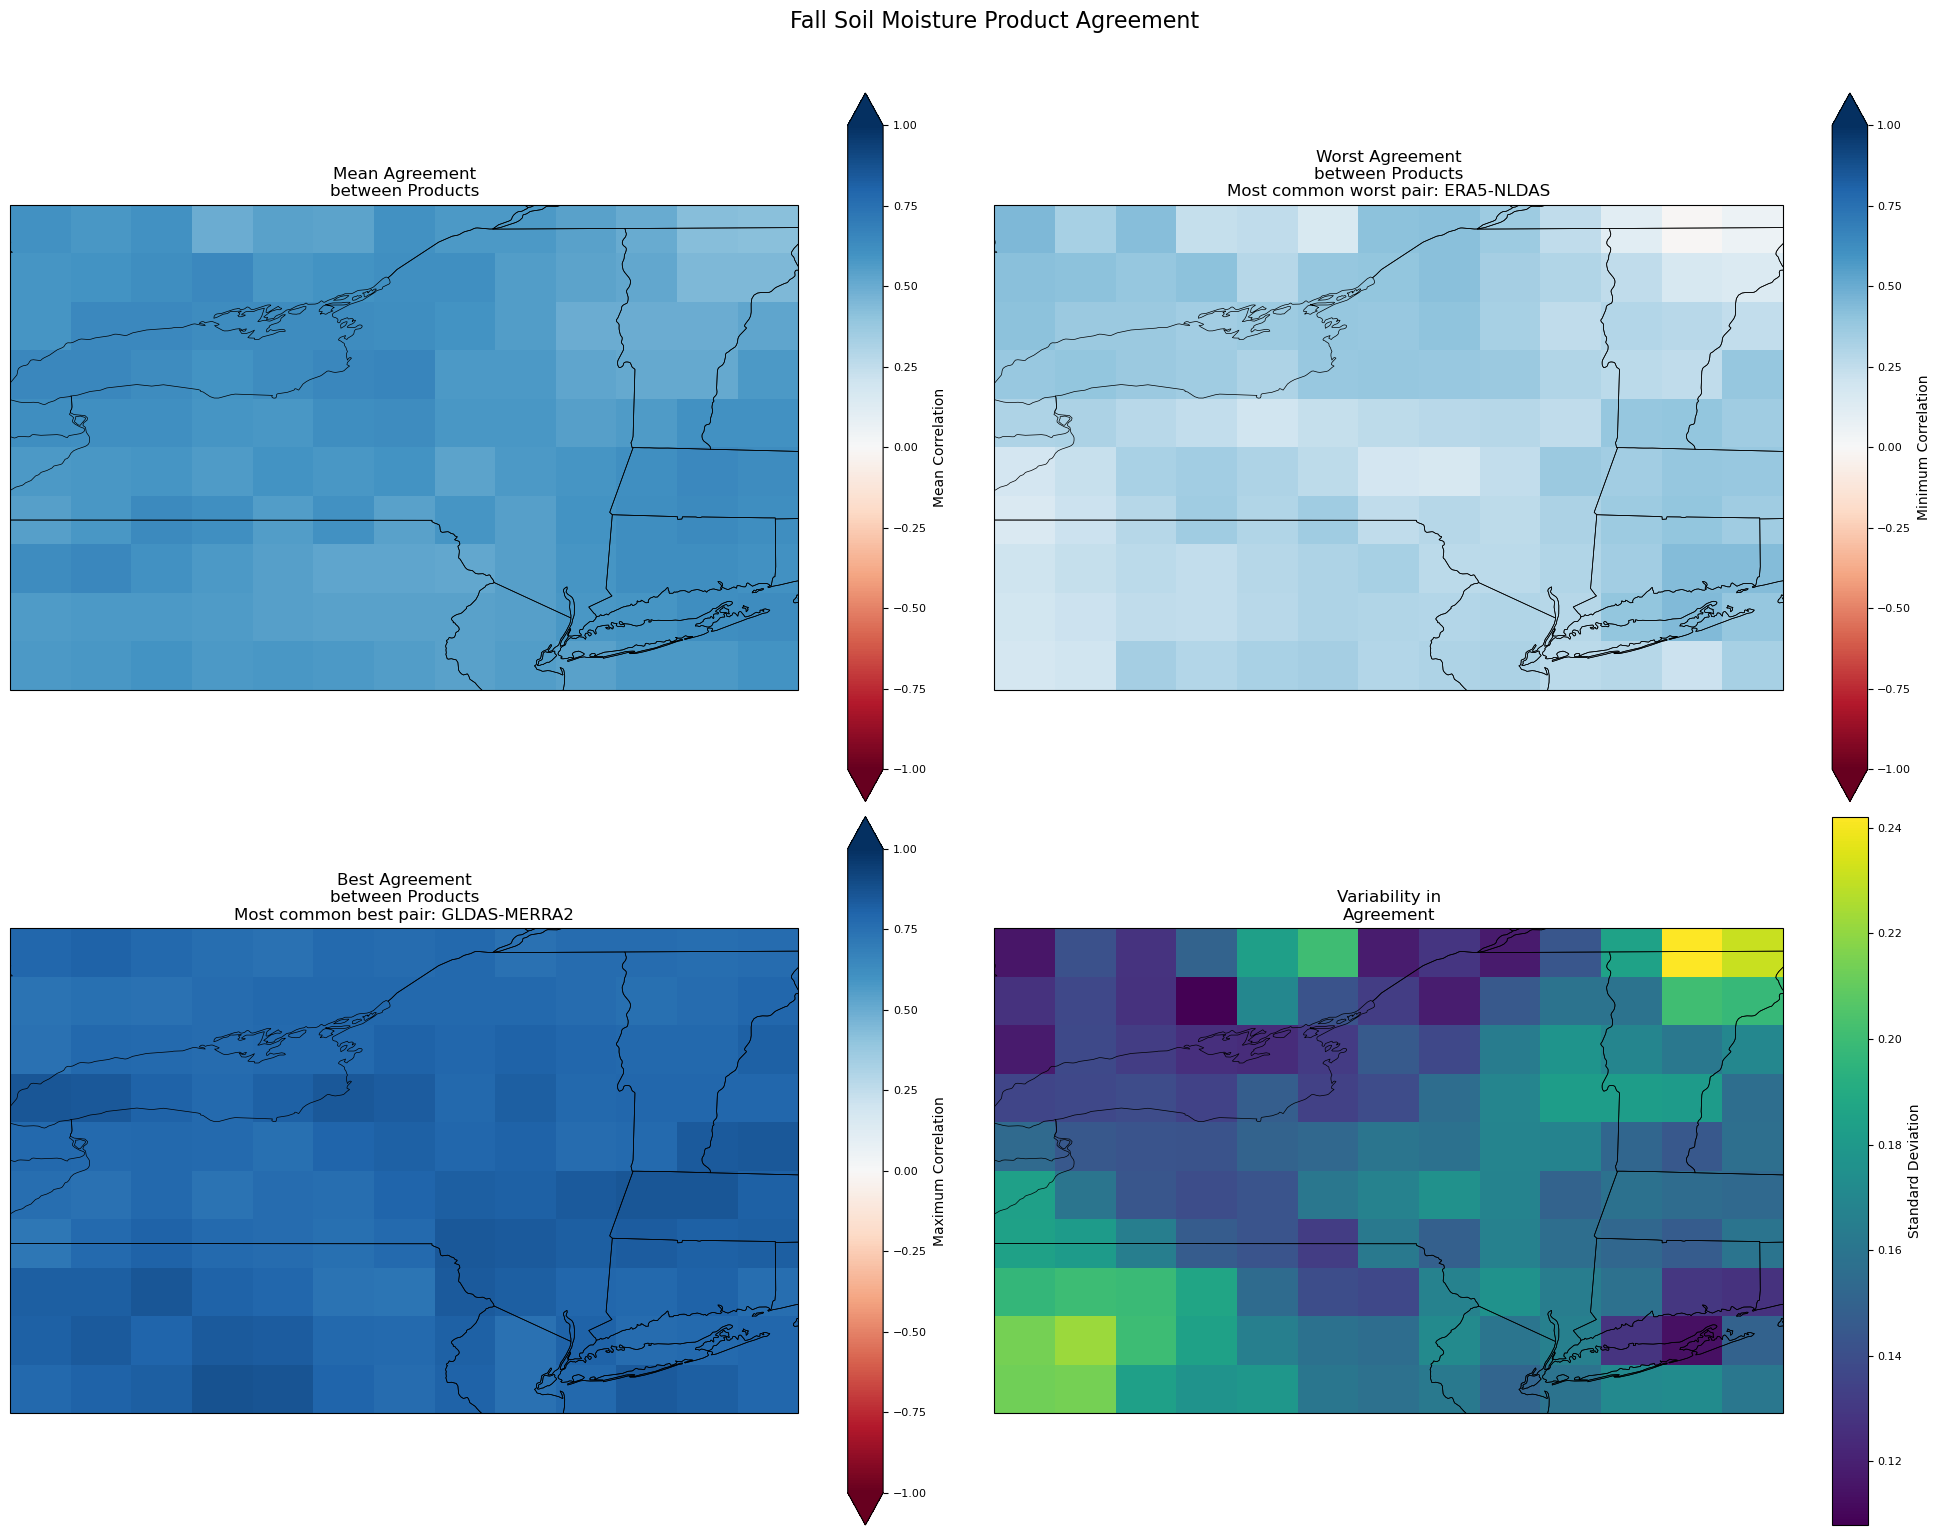


=== Fall Statistics ===

mean_correlation:
Mean: 0.579
Median: 0.581
Min: 0.421
Max: 0.660

max_correlation:
Mean: 0.794
Median: 0.789
Min: 0.719
Max: 0.874

min_correlation:
Mean: 0.305
Median: 0.306
Min: -0.012
Max: 0.453

correlation_std:
Mean: 0.158
Median: 0.157
Min: 0.108
Max: 0.242


In [ ]:
import xarray as xr
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.colors import LinearSegmentedColormap
import cartopy.crs as ccrs
import cartopy.feature as cfeature
import pandas as pd

def get_season(month):
    """Convert month number to season name"""
    if month in [12, 1, 2]:
        return 'Winter'
    elif month in [3, 4, 5]:
        return 'Spring'
    elif month in [6, 7, 8]:
        return 'Summer'
    else:
        return 'Fall'

def decompose_by_season(data):
    """Split data into seasonal components"""
    if isinstance(data, xr.Dataset):
        if 'SFMC' in data:
            data = data['SFMC']
        elif 'SoilM_0_10cm' in data:
            data = data['SoilM_0_10cm']
        elif 'SoilMoi00_10cm_tavg' in data:
            data = data['SoilMoi00_10cm_tavg']
        elif 'SoilMoi0_10cm_inst' in data:
            data = data['SoilMoi0_10cm_inst']
        elif 'swvl1' in data:
            data = data['swvl1']
    
    months = pd.DatetimeIndex(data.time.values).month
    seasons = [get_season(m) for m in months]
    
    seasonal_data = {}
    for season in ['Winter', 'Spring', 'Summer', 'Fall']:
        season_mask = [s == season for s in seasons]
        seasonal_data[season] = data.isel(time=season_mask)
    
    return seasonal_data

def calculate_seasonal_metrics(datasets_dict):
    """Calculate detailed spatial metrics for each season"""
    
    seasonal_datasets = {}
    for name, data in datasets_dict.items():
        seasonal_datasets[name] = decompose_by_season(data)
        print(f"\nDecomposed {name} into seasons")
    
    seasonal_metrics = {}
    
    for season in ['Winter', 'Spring', 'Summer', 'Fall']:
        print(f"\nProcessing {season}")
        
        season_data = {}
        for name in datasets_dict.keys():
            season_data[name] = seasonal_datasets[name][season]
        
        min_lat = min(data.shape[1] for data in season_data.values())
        min_lon = min(data.shape[2] for data in season_data.values())
        
        mean_correlation = np.zeros((min_lat, min_lon))
        max_correlation = np.zeros((min_lat, min_lon))
        min_correlation = np.zeros((min_lat, min_lon))
        correlation_std = np.zeros((min_lat, min_lon))
        best_pairs = np.empty((min_lat, min_lon), dtype='U20')
        worst_pairs = np.empty((min_lat, min_lon), dtype='U20')
        
        for i in range(min_lat):
            for j in range(min_lon):
                correlations = []
                pairs = []
                
                for name1, data1 in season_data.items():
                    for name2, data2 in season_data.items():
                        if name1 < name2:
                            try:
                                ts1 = data1[:, i, j]
                                ts2 = data2[:, i, j]
                                
                                d1 = ts1.values if hasattr(ts1, 'values') else ts1
                                d2 = ts2.values if hasattr(ts2, 'values') else ts2
                                
                                valid_mask = ~(np.isnan(d1) | np.isnan(d2))
                                if valid_mask.any():
                                    d1_valid = d1[valid_mask]
                                    d2_valid = d2[valid_mask]
                                    
                                    if len(d1_valid) >= 2:
                                        corr = np.corrcoef(d1_valid, d2_valid)[0,1]
                                        if not np.isnan(corr):
                                            correlations.append(corr)
                                            pairs.append(f"{name1}-{name2}")
                            
                            except Exception as e:
                                continue
                
                if correlations:
                    mean_correlation[i,j] = np.mean(correlations)
                    max_idx = np.argmax(correlations)
                    min_idx = np.argmin(correlations)
                    max_correlation[i,j] = correlations[max_idx]
                    min_correlation[i,j] = correlations[min_idx]
                    correlation_std[i,j] = np.std(correlations)
                    best_pairs[i,j] = pairs[max_idx]
                    worst_pairs[i,j] = pairs[min_idx]
                else:
                    mean_correlation[i,j] = np.nan
                    max_correlation[i,j] = np.nan
                    min_correlation[i,j] = np.nan
                    correlation_std[i,j] = np.nan
        
        ref_data = season_data['MERRA2']
        try:
            lats = ref_data.lat.values[:min_lat]
            lons = ref_data.lon.values[:min_lon]
        except AttributeError:
            try:
                lats = ref_data.latitude.values[:min_lat]
                lons = ref_data.longitude.values[:min_lon]
            except AttributeError:
                lats = np.arange(min_lat)
                lons = np.arange(min_lon)
        
        seasonal_metrics[season] = {
            'mean_correlation': xr.DataArray(
                mean_correlation,
                coords={'latitude': lats, 'longitude': lons},
                dims=['latitude', 'longitude']
            ),
            'max_correlation': xr.DataArray(
                max_correlation,
                coords={'latitude': lats, 'longitude': lons},
                dims=['latitude', 'longitude']
            ),
            'min_correlation': xr.DataArray(
                min_correlation,
                coords={'latitude': lats, 'longitude': lons},
                dims=['latitude', 'longitude']
            ),
            'correlation_std': xr.DataArray(
                correlation_std,
                coords={'latitude': lats, 'longitude': lons},
                dims=['latitude', 'longitude']
            ),
            'best_pairs': best_pairs,
            'worst_pairs': worst_pairs
        }
    
    return seasonal_metrics

def plot_season_detailed(metrics, season):
    """Create detailed 4-panel map for a single season with support for negative correlations"""
    
    fig = plt.figure(figsize=(20, 15))
    
    # Create blue to red colormap
    colors = ['#053061', '#2166ac', '#4393c3', '#92c5de', '#d1e5f0',
              '#f7f7f7', '#fddbc7', '#f4a582', '#d6604d', '#b2182b', '#67001f']
    colors.reverse()
    cmap = LinearSegmentedColormap.from_list('custom_blue_red', colors)
    
    proj = ccrs.PlateCarree()
    
    # Plot configurations with specific labels for each metric and appropriate value ranges
    plots = [
        ('mean_correlation', 'Mean Agreement\nbetween Products', cmap, 'Mean Correlation', True),
        ('min_correlation', 'Worst Agreement\nbetween Products', cmap, 'Minimum Correlation', True),
        ('max_correlation', 'Best Agreement\nbetween Products', cmap, 'Maximum Correlation', True),
        ('correlation_std', 'Variability in\nAgreement', 'viridis', 'Standard Deviation', False)
    ]
    
    for idx, (metric, title, colormap, label, use_correlation_range) in enumerate(plots, 1):
        ax = fig.add_subplot(2, 2, idx, projection=proj)
        
        # Get most common pairs for best/worst agreement if relevant
        if metric == 'max_correlation':
            unique_pairs, counts = np.unique(metrics['best_pairs'], return_counts=True)
            most_common = unique_pairs[np.argmax(counts)]
            title += f'\nMost common best pair: {most_common}'
        elif metric == 'min_correlation':
            unique_pairs, counts = np.unique(metrics['worst_pairs'], return_counts=True)
            most_common = unique_pairs[np.argmax(counts)]
            title += f'\nMost common worst pair: {most_common}'
        
        # Set value ranges based on metric type
        if use_correlation_range:
            data = metrics[metric].values
            valid_data = data[~np.isnan(data)]
            vmin = min(-1, np.min(valid_data)) if len(valid_data) > 0 else -1
            vmax = max(1, np.max(valid_data)) if len(valid_data) > 0 else 1
            extend = 'both'
            center = 0
        else:
            vmin = None
            vmax = None
            extend = 'neither'
            center = None
        
        im = metrics[metric].plot(
            ax=ax,
            transform=proj,
            cmap=colormap,
            vmin=vmin,
            vmax=vmax,
            center=center,
            cbar_kwargs={
                'label': label,
                'extend': extend
            }
        )
        
        ax.set_title(title)
        ax.coastlines(linewidth=0.5)
        ax.add_feature(cfeature.STATES, linewidth=0.5)
        
        # Adjust colorbar with proper label
        cb = im.colorbar
        cb.set_label(label, size=10)
        cb.ax.tick_params(labelsize=8)
    
    plt.suptitle(f'{season} Soil Moisture Product Agreement', 
                 fontsize=16, y=1.02)
    plt.tight_layout()
    
    return fig
# Create dictionary of datasets
datasets = {
    'MERRA2': merra2_data,
    'NLDAS': nldas_data,
    'FLDAS': fldas_data,
    'GLDAS': gldas_data,
    'ERA5': era5_data
}

# Calculate seasonal metrics
seasonal_metrics = calculate_seasonal_metrics(datasets)

# Create separate plots for each season
for season in ['Winter', 'Spring', 'Summer', 'Fall']:
    fig = plot_season_detailed(seasonal_metrics[season], season)
    plt.show()
    
    # Print summary statistics for this season
    print(f"\n=== {season} Statistics ===")
    
    for metric in ['mean_correlation', 'max_correlation', 'min_correlation', 'correlation_std']:
        data = seasonal_metrics[season][metric].values
        valid_data = data[~np.isnan(data)]
        if len(valid_data) > 0:
            print(f"\n{metric}:")
            print(f"Mean: {np.mean(valid_data):.3f}")
            print(f"Median: {np.median(valid_data):.3f}")
            print(f"Min: {np.min(valid_data):.3f}")
            print(f"Max: {np.max(valid_data):.3f}")
